In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

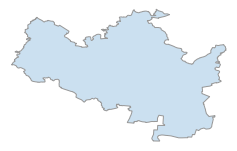

{'init': 'epsg:4326'}


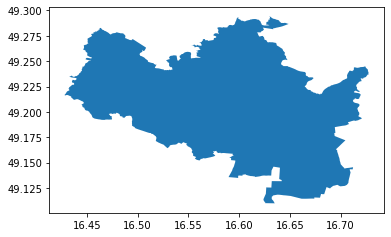

time: 393 ms


In [2]:
city = ox.gdf_from_place('Brno, Czech Republic')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

417
data max index: 416
number of NA prices: 0
average bedroom price 62.24291994975449
pointinpoly length: 417
check contains: True
check if there are NAs: False


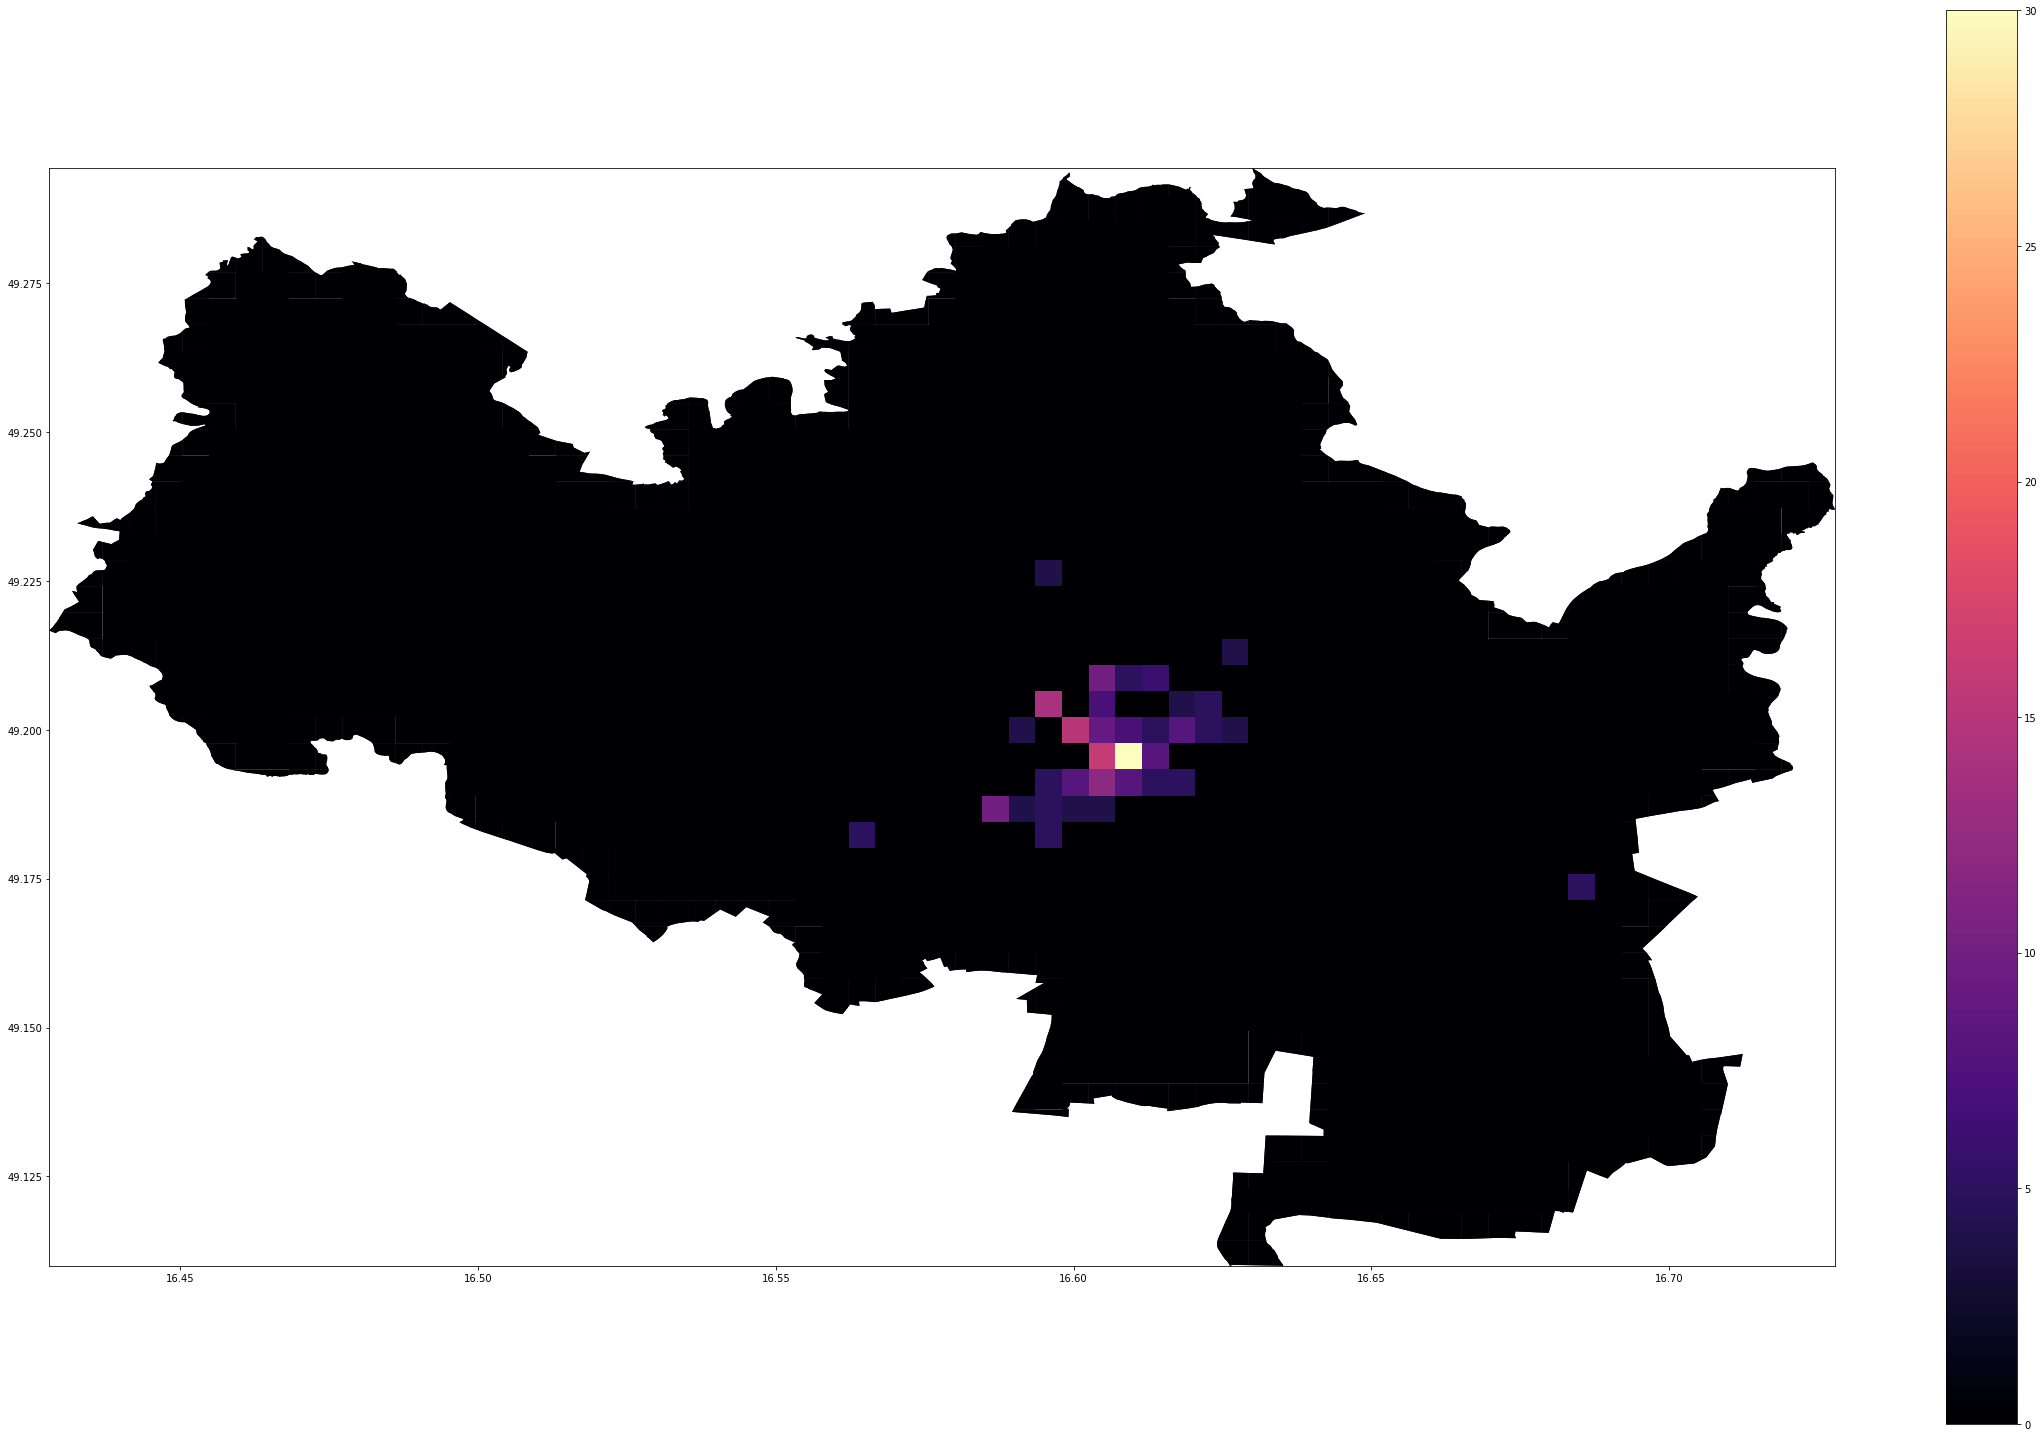

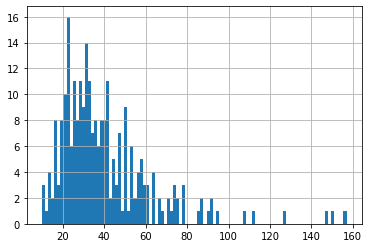

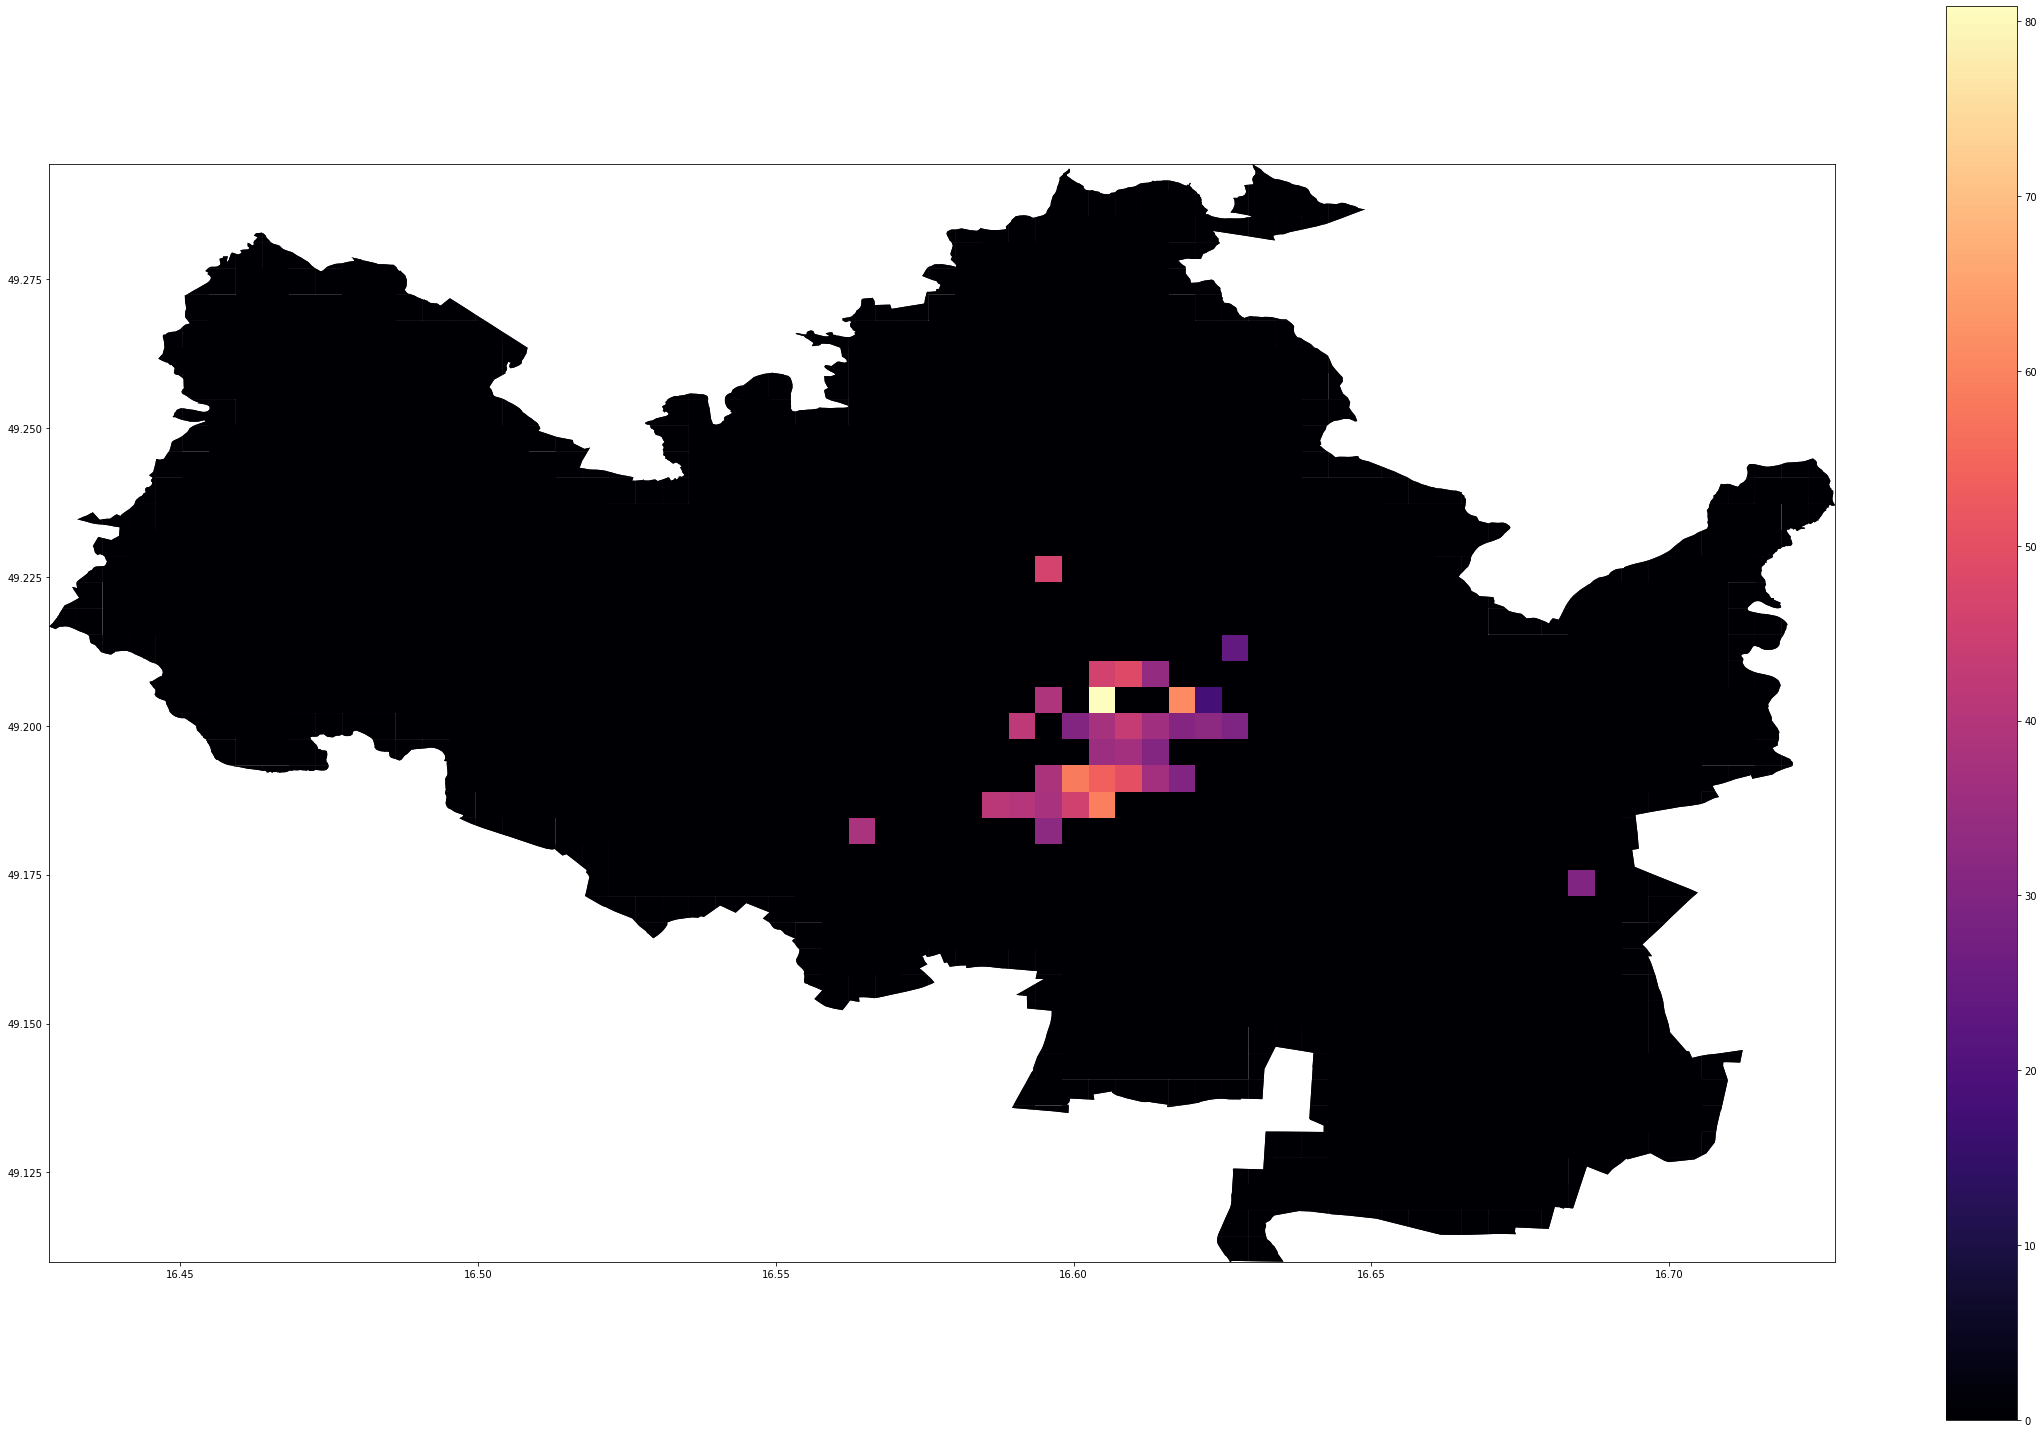

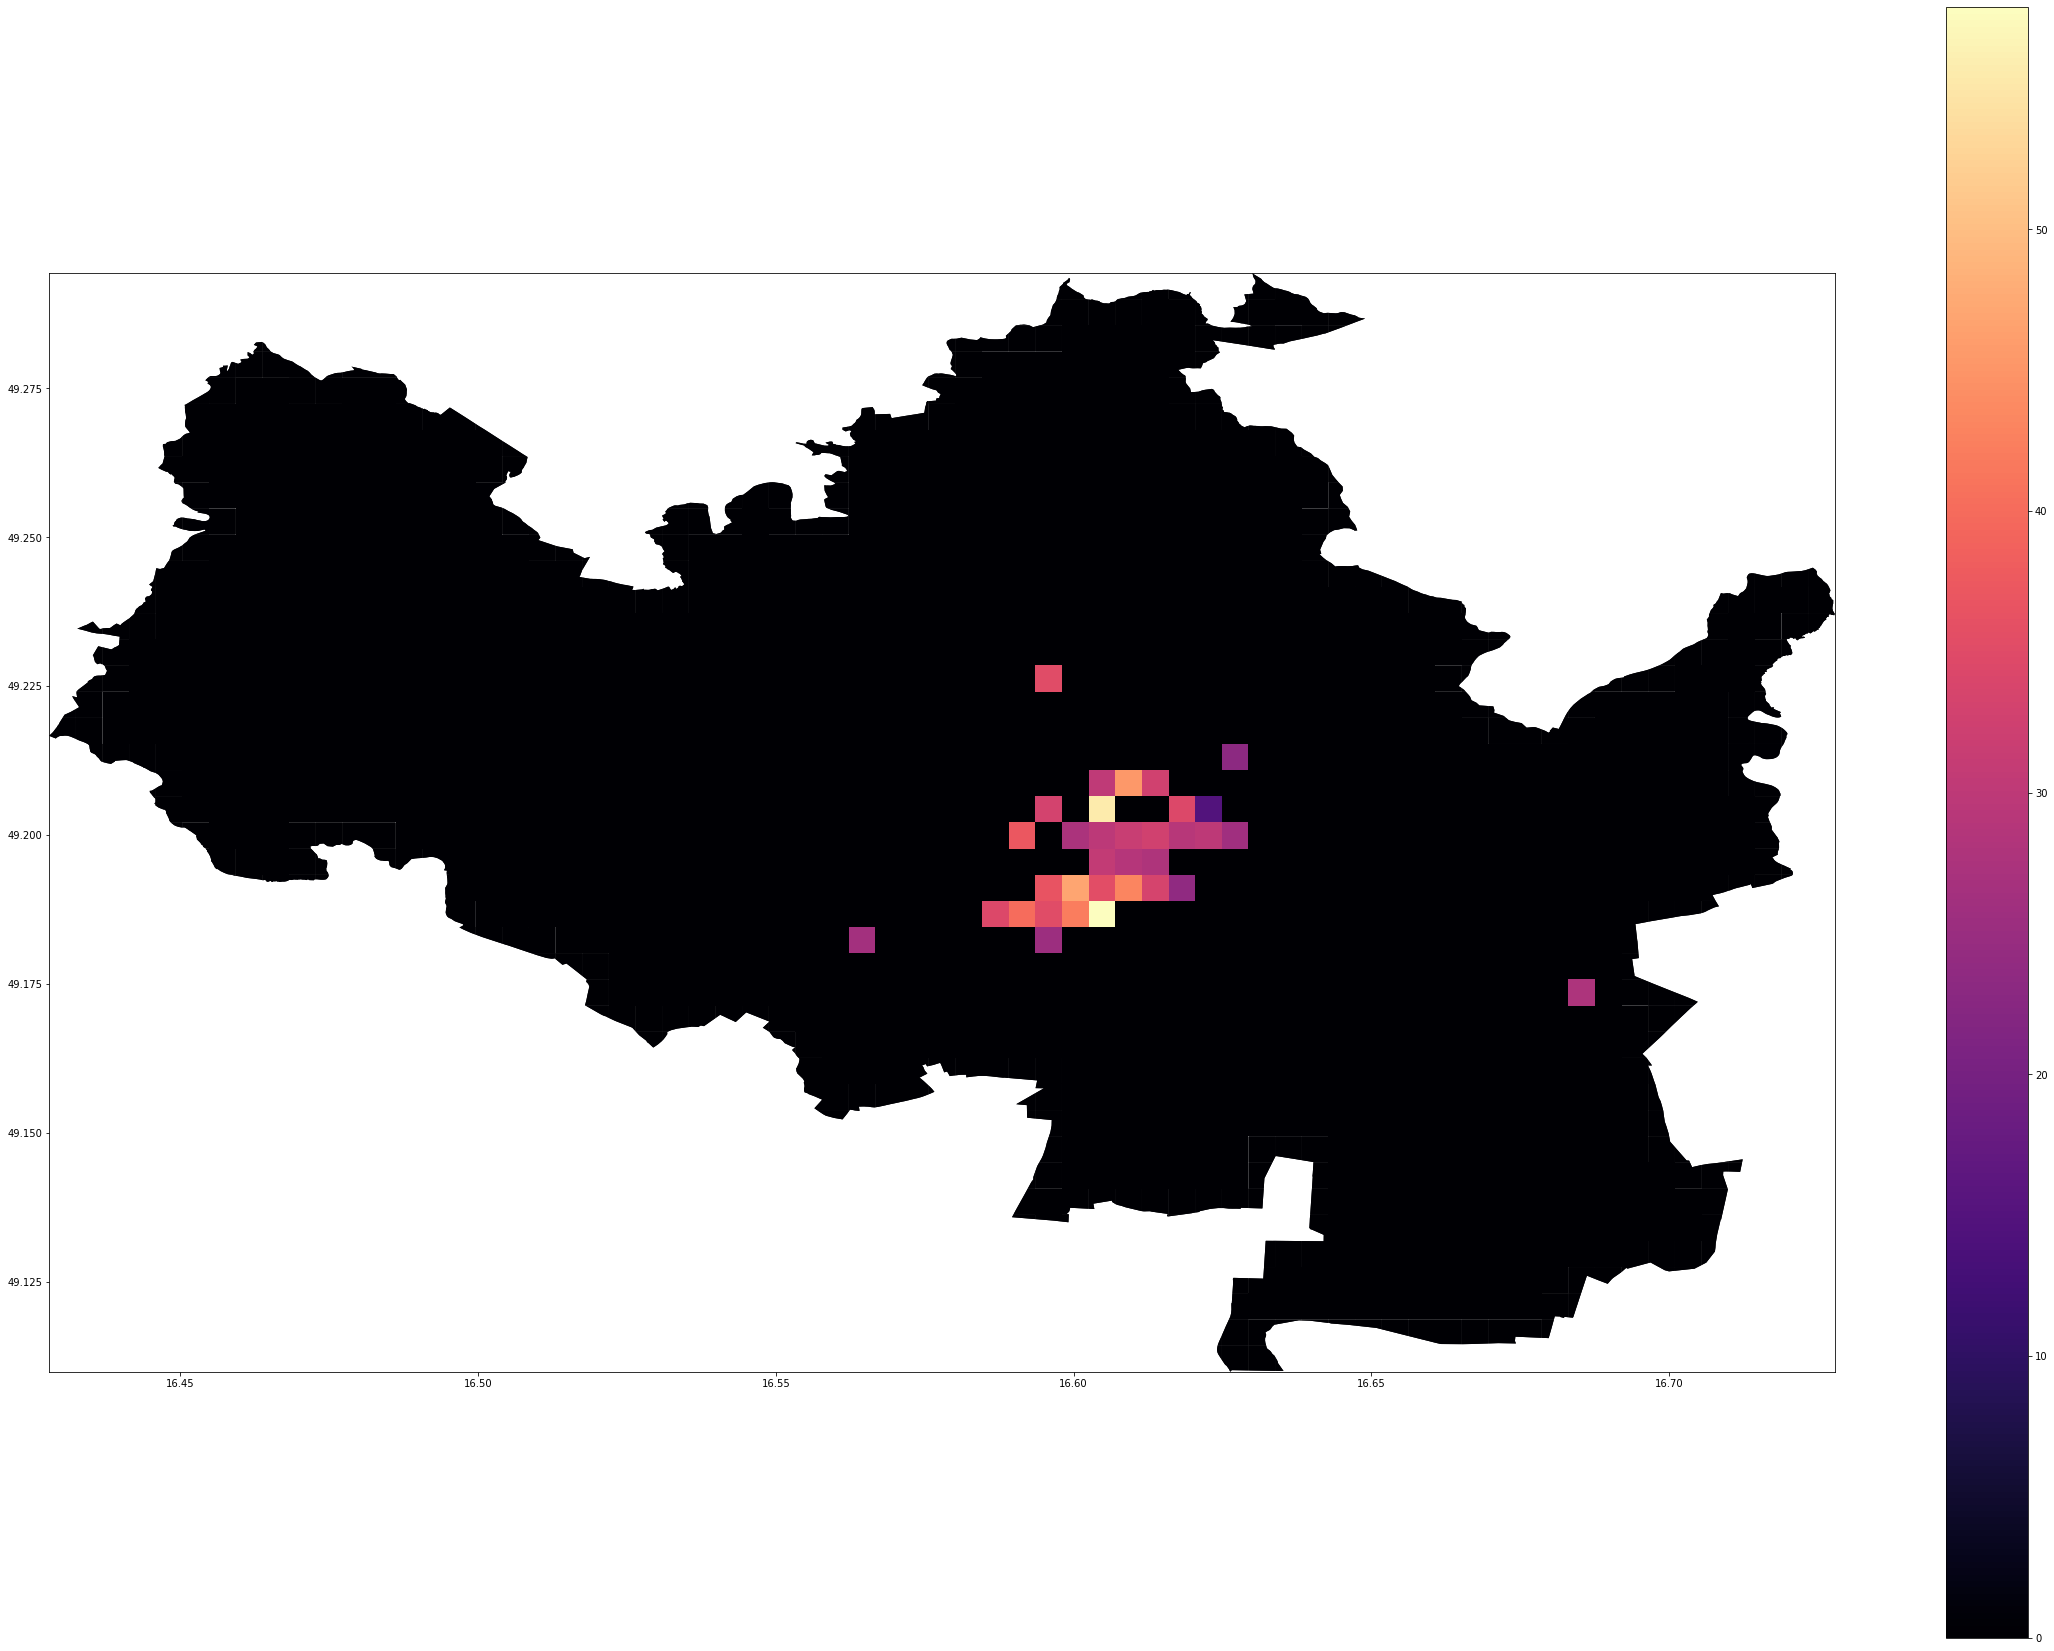

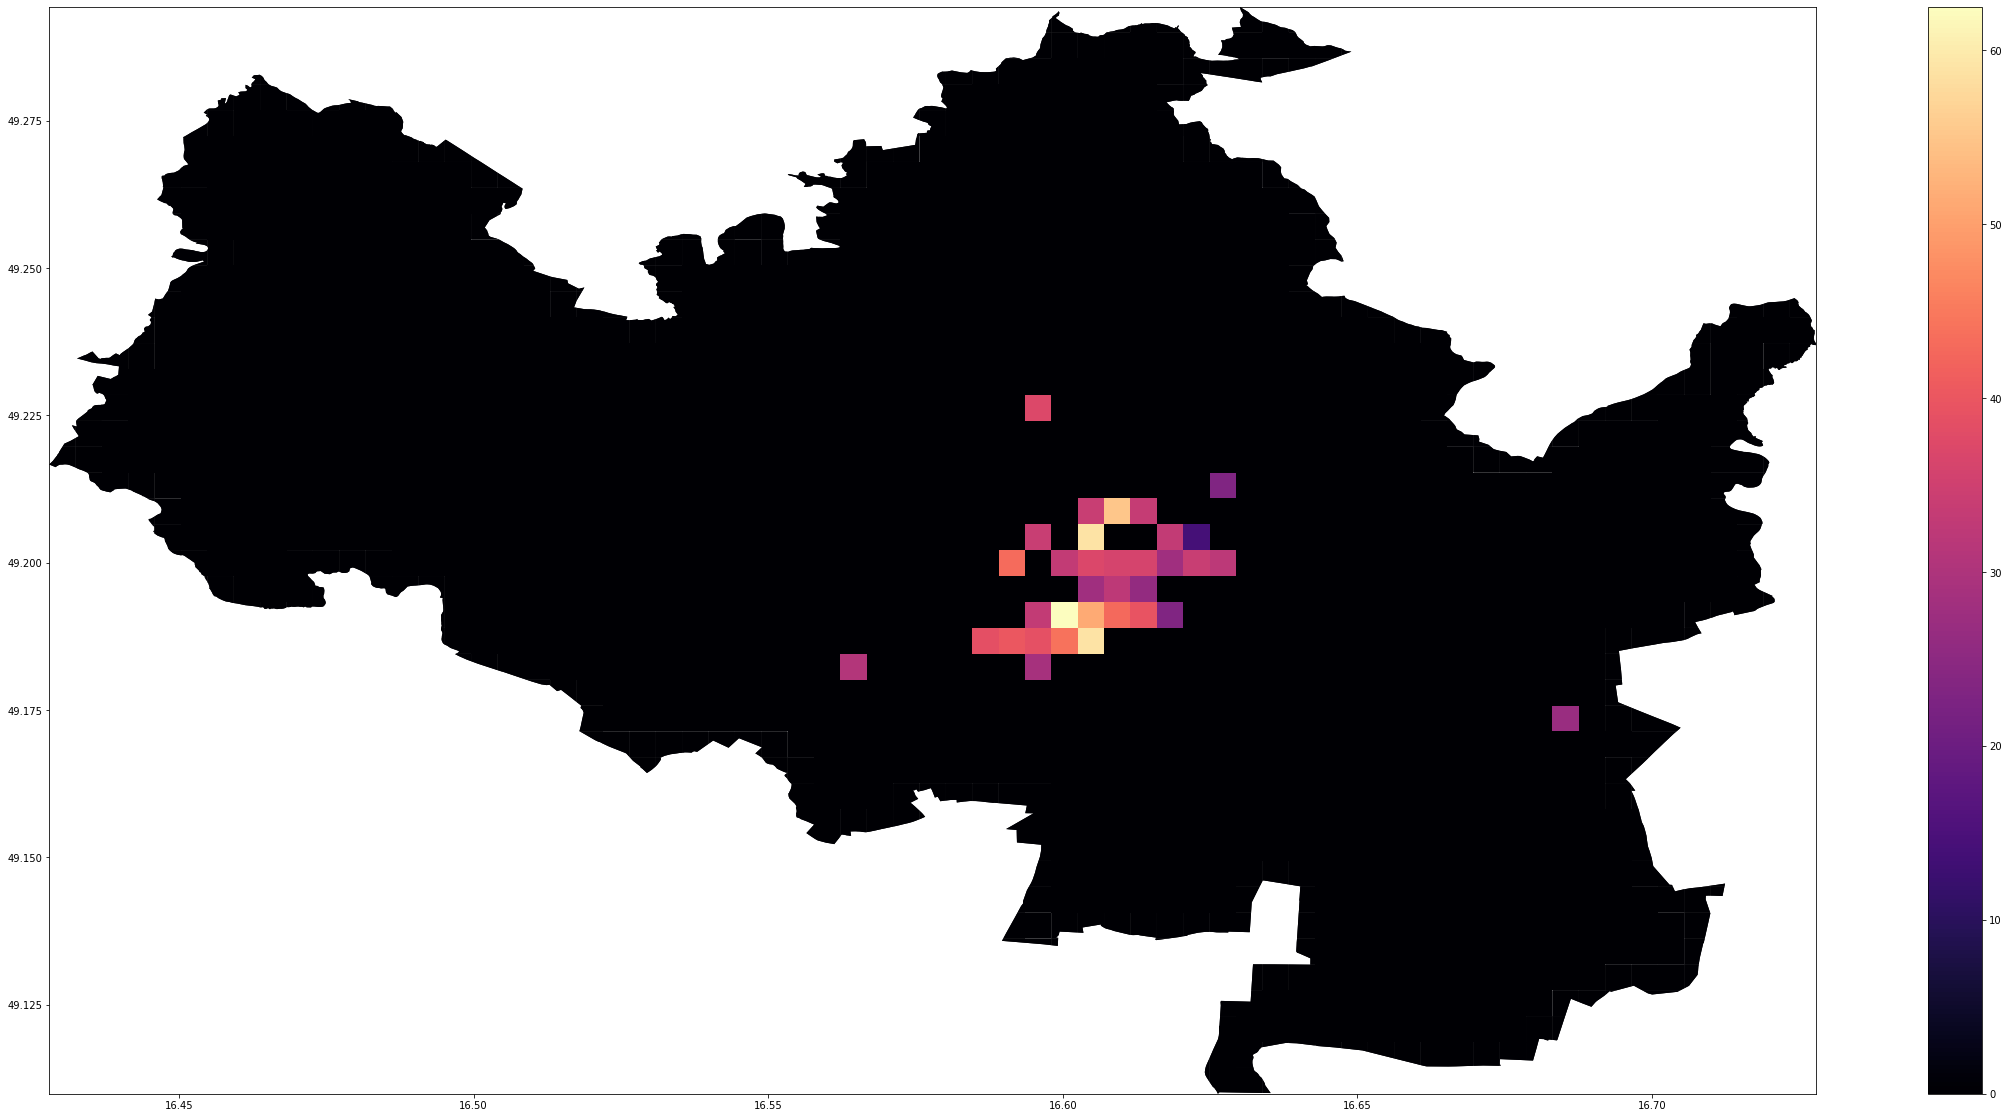

time: 9.26 s


In [3]:
data = pd.read_csv('data/Airbnb_Brno.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>3]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


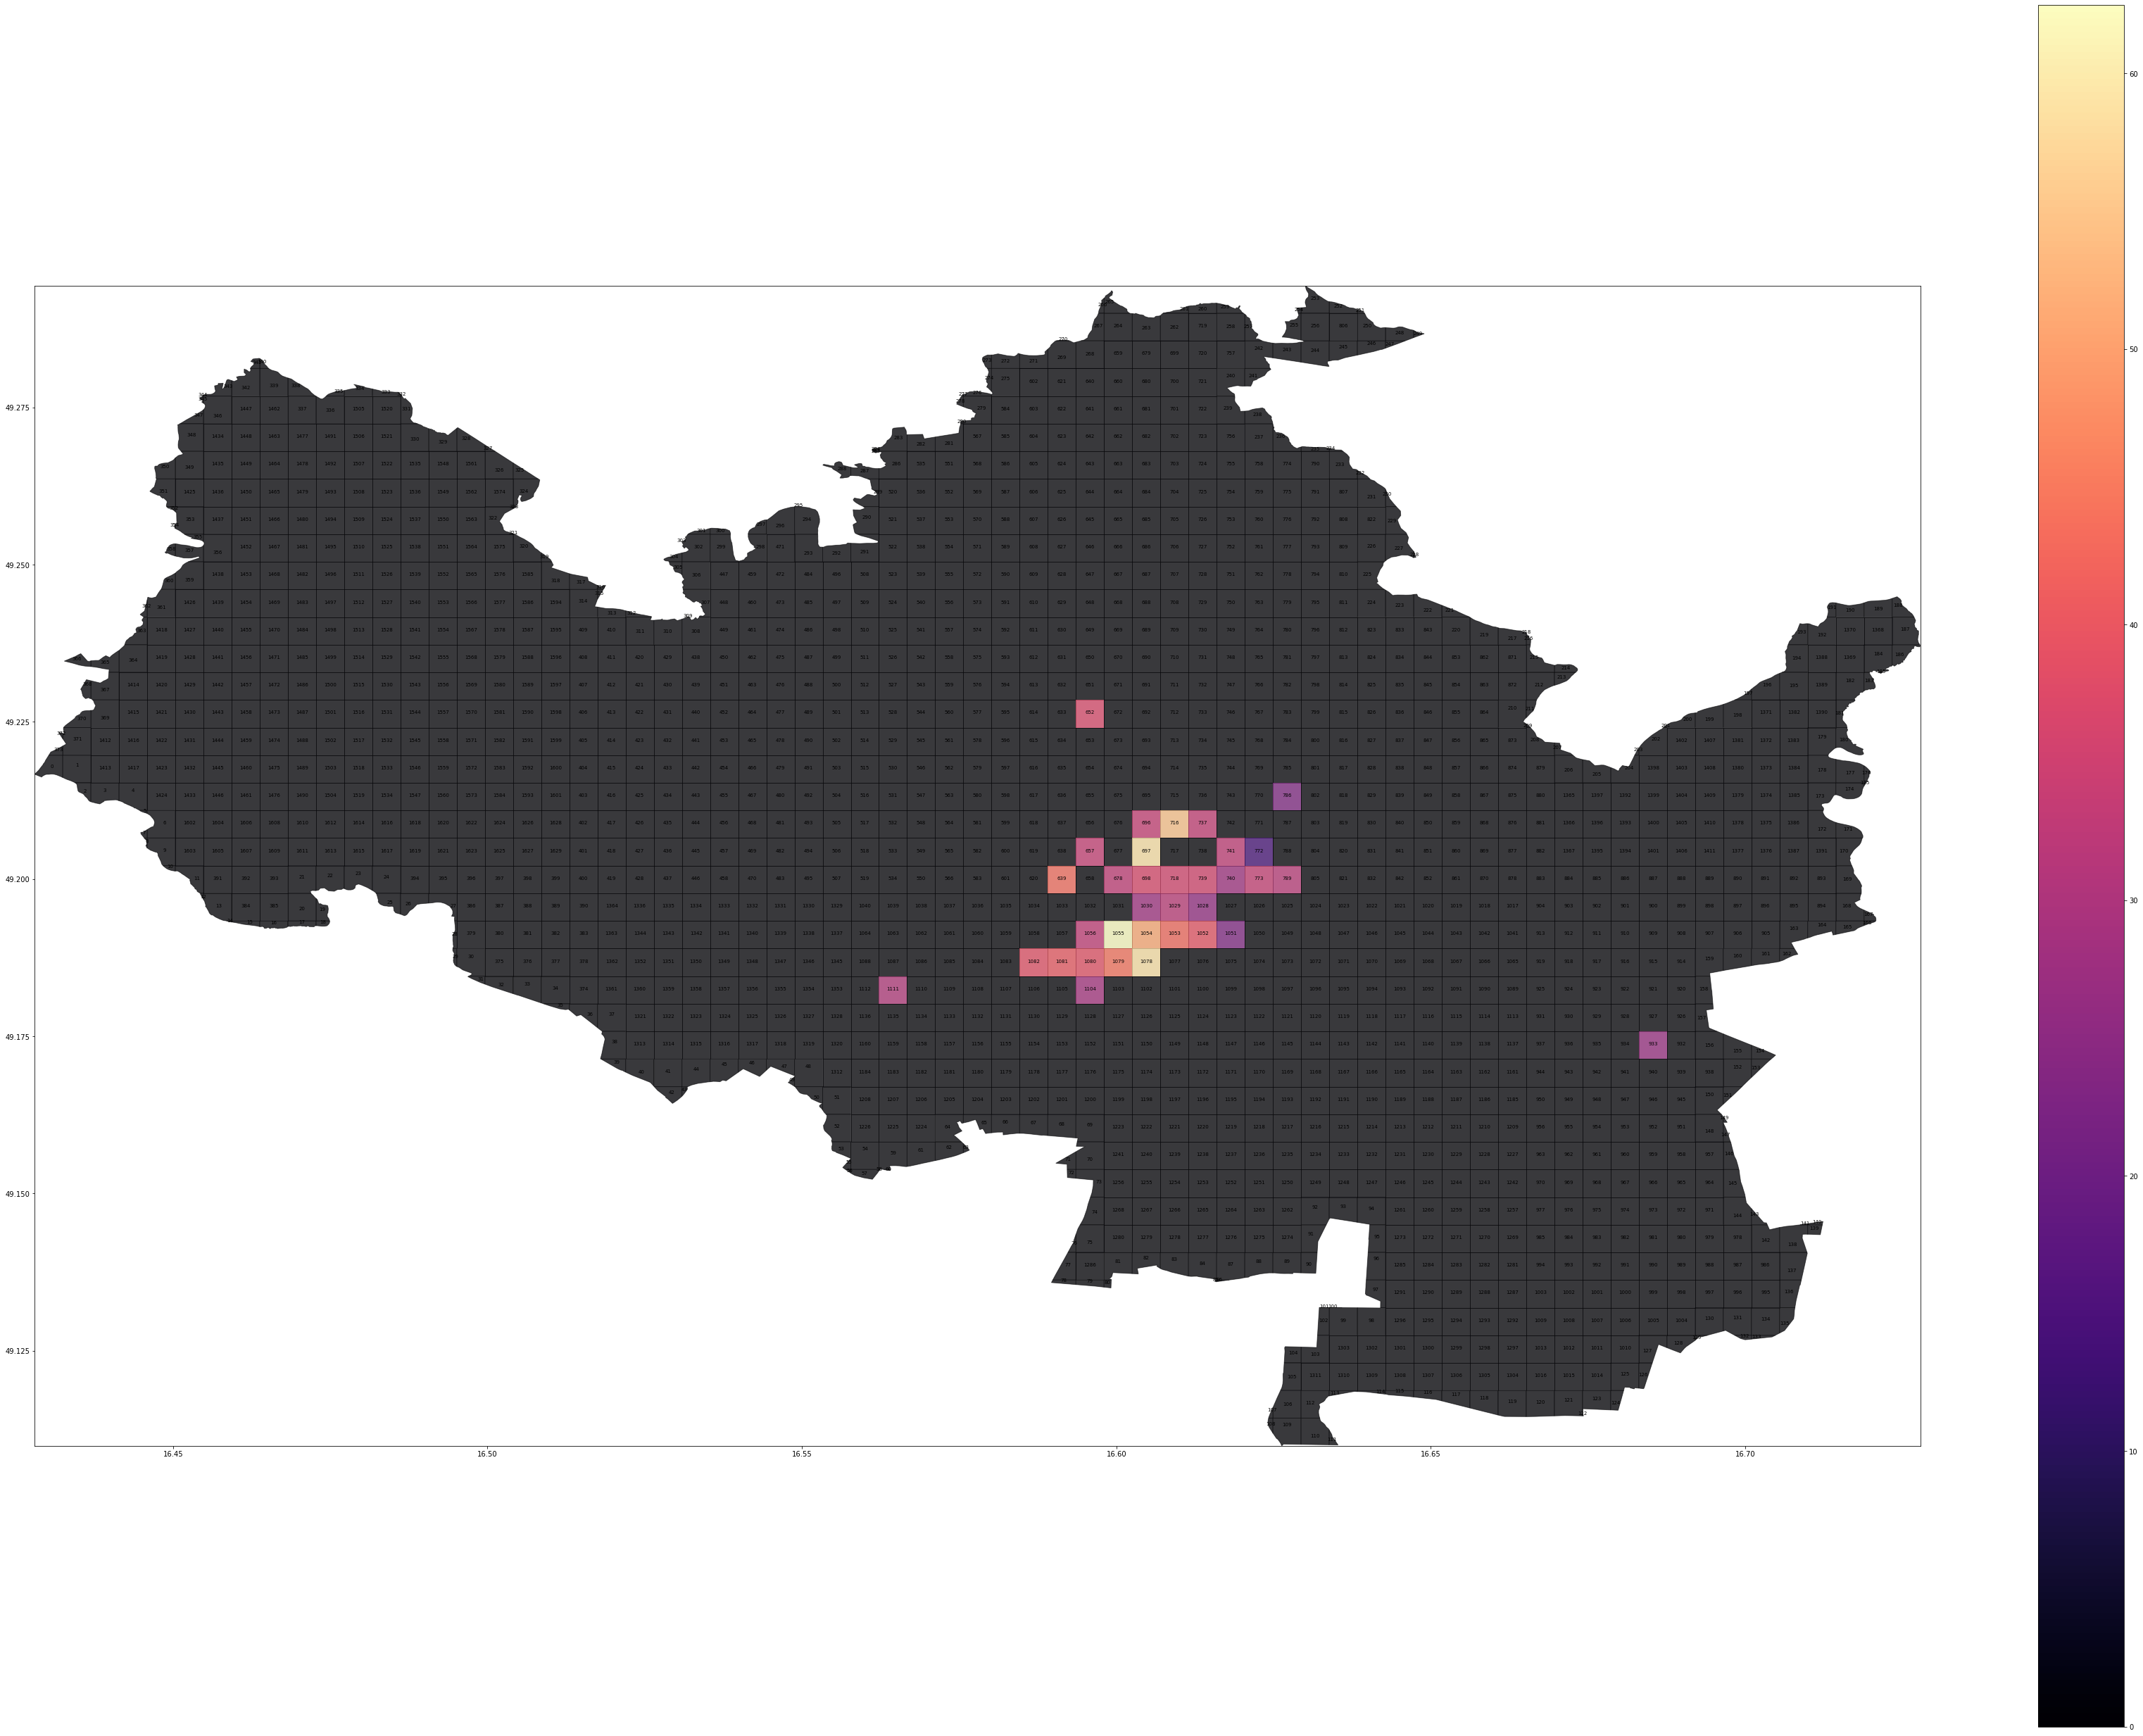

time: 18.3 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(60,45))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

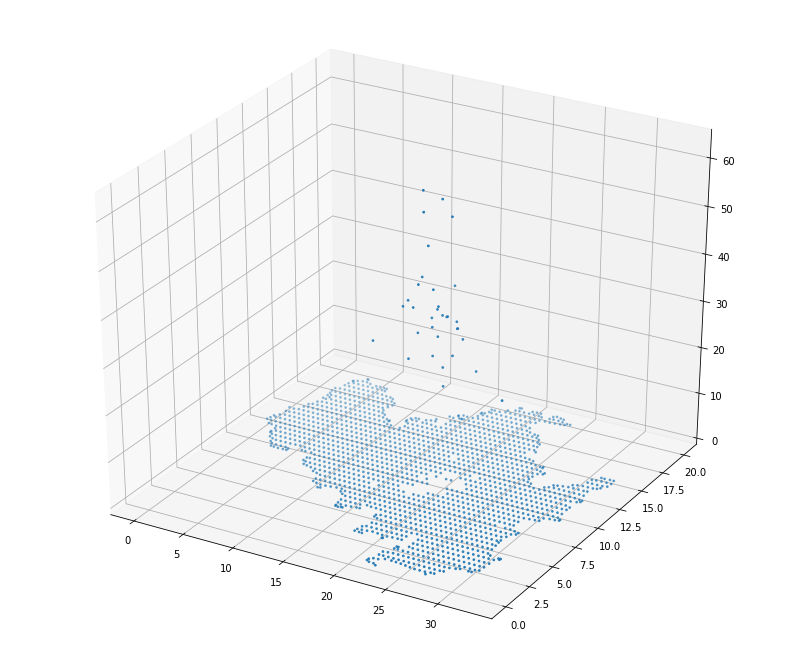

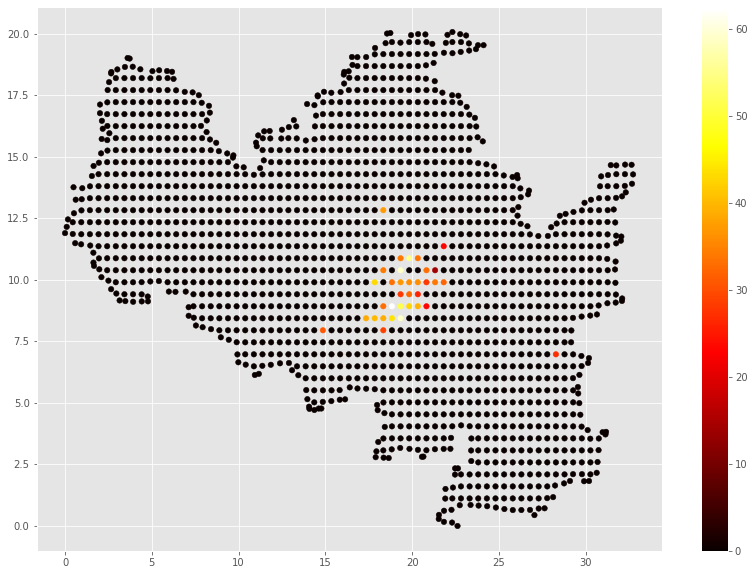

time: 2.21 s


In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Brno_observed.jpg')
plt.show()

In [6]:
polyair[polyair.median_prices==polyair.median_prices.max()]

geometry  center_lon  \
1055  POLYGON ((16.60252632536863 49.19333990475741,...   16.600289   

      center_lat  count  prices  hmean_prices  median_prices  
1055   49.191144      8  58.625     47.011833           62.5

time: 18 ms


In [7]:
cdf = polyair[polyair.index.isin([1055, 697])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
697   POLYGON ((16.60252632537764 49.20651784761455,...   16.604764   
1055  POLYGON ((16.60252632536863 49.19333990475741,...   16.600289   

      center_lat  count     prices  hmean_prices  median_prices  cen_lon_km  \
697    49.204322      7  80.857143     55.617804           59.0   19.335419   
1055   49.191144      8  58.625000     47.011833           62.5   18.838125   

      cen_lat_km  
697    10.393903  
1055    8.929570

time: 279 ms


Fitted parameters:
[8.43344801e+02 1.95992168e+01 1.06370870e+01 3.42346661e-02
 1.10453447e-02 2.65240855e+00 2.22903888e-01 4.17740168e+01
 1.95367600e+01 9.11121490e+00 1.65747525e+00 5.12007887e-01
 2.66215132e+00 1.89425429e+00]
RMS residual = 3.133134847120869


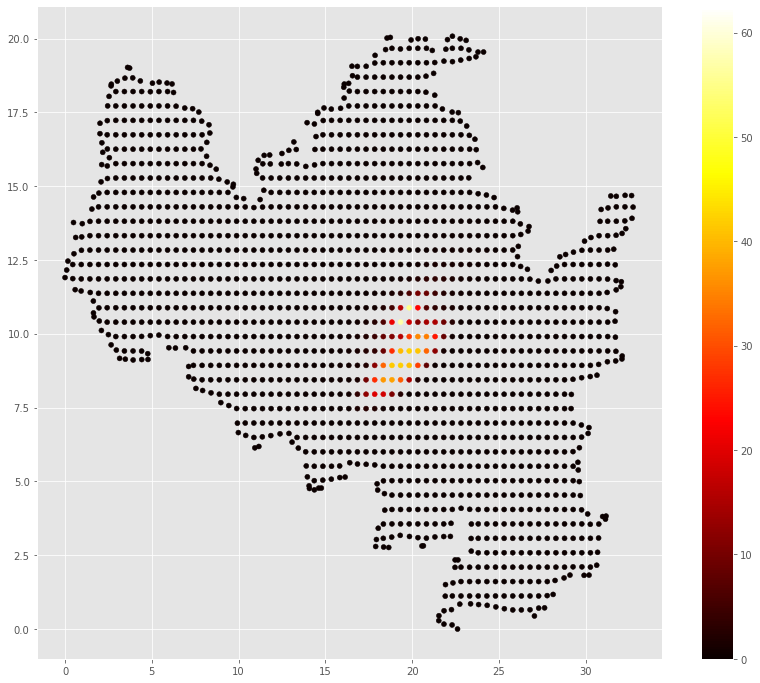

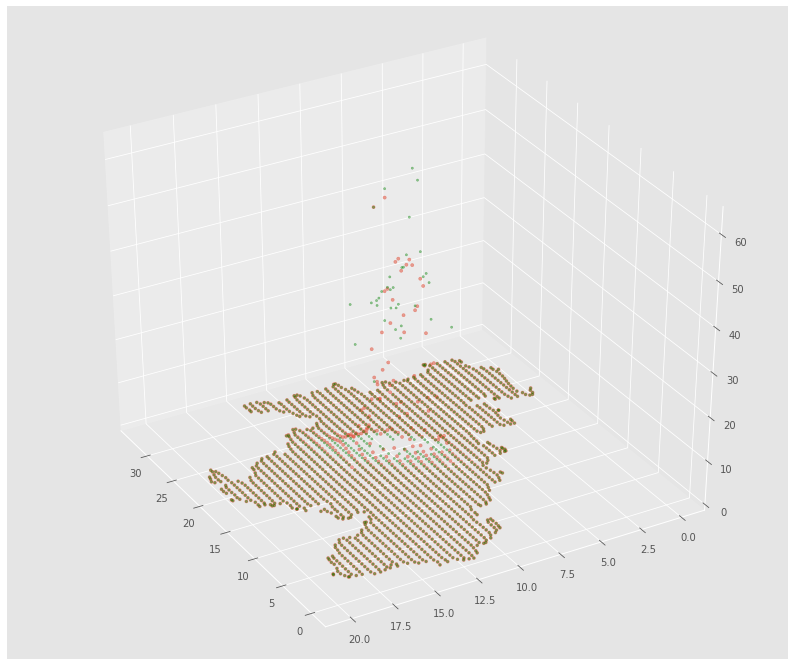

{'Brno': 1.0585790881785773}
time: 2.53 s


In [8]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(59,19.335419,10.393903, 1.1, 0.64,3.1, 1.5),
              (62.5,18.838125,8.929570, 1, 0.8,1.97, 1.18),
              #(54,33.195764,9.446164, 1, 0.5,1.87, 0.7),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Brno_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Brno'] = np.mean(popt[6::7])
print(alphas)

In [9]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Brno'] = alphas['Brno']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[36.77933455 19.82011544 10.13741979  1.16505899  0.64012154  3.17734302
 69.73176321 18.90655656  8.68411521 -1.0057173   0.27709138  2.96752451]
RMS residual = 3.1779339744082153


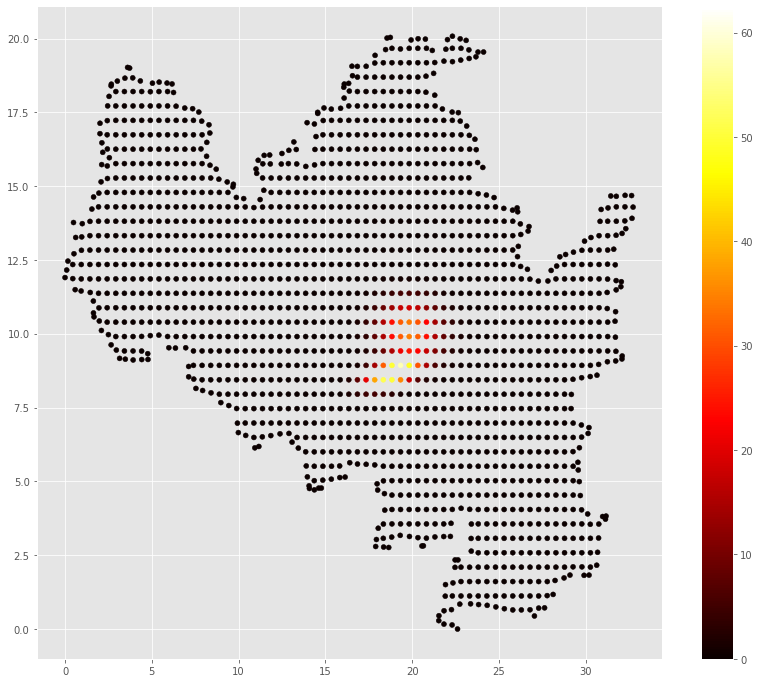

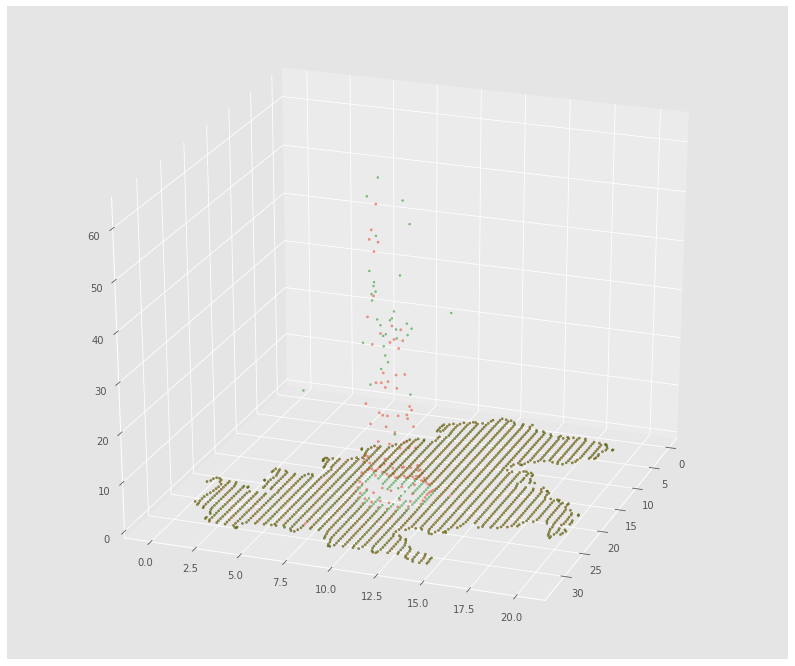

time: 947 ms


In [10]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr



guess_prms = [(59,19.335419,10.393903, 1.5, 2,1.5),
              (62.5,18.838125,8.929570, 2, 1,1.87),
              #(54,33.195764,9.446164, 1, 0.5,1.87, 0.7),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Brno_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [11]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
long stds:  [0.03003438 0.03659581] mean:  0.03331509508643077
short stds:  [0.01650187 0.01008274] mean:  0.013292304543859903
time: 37 ms


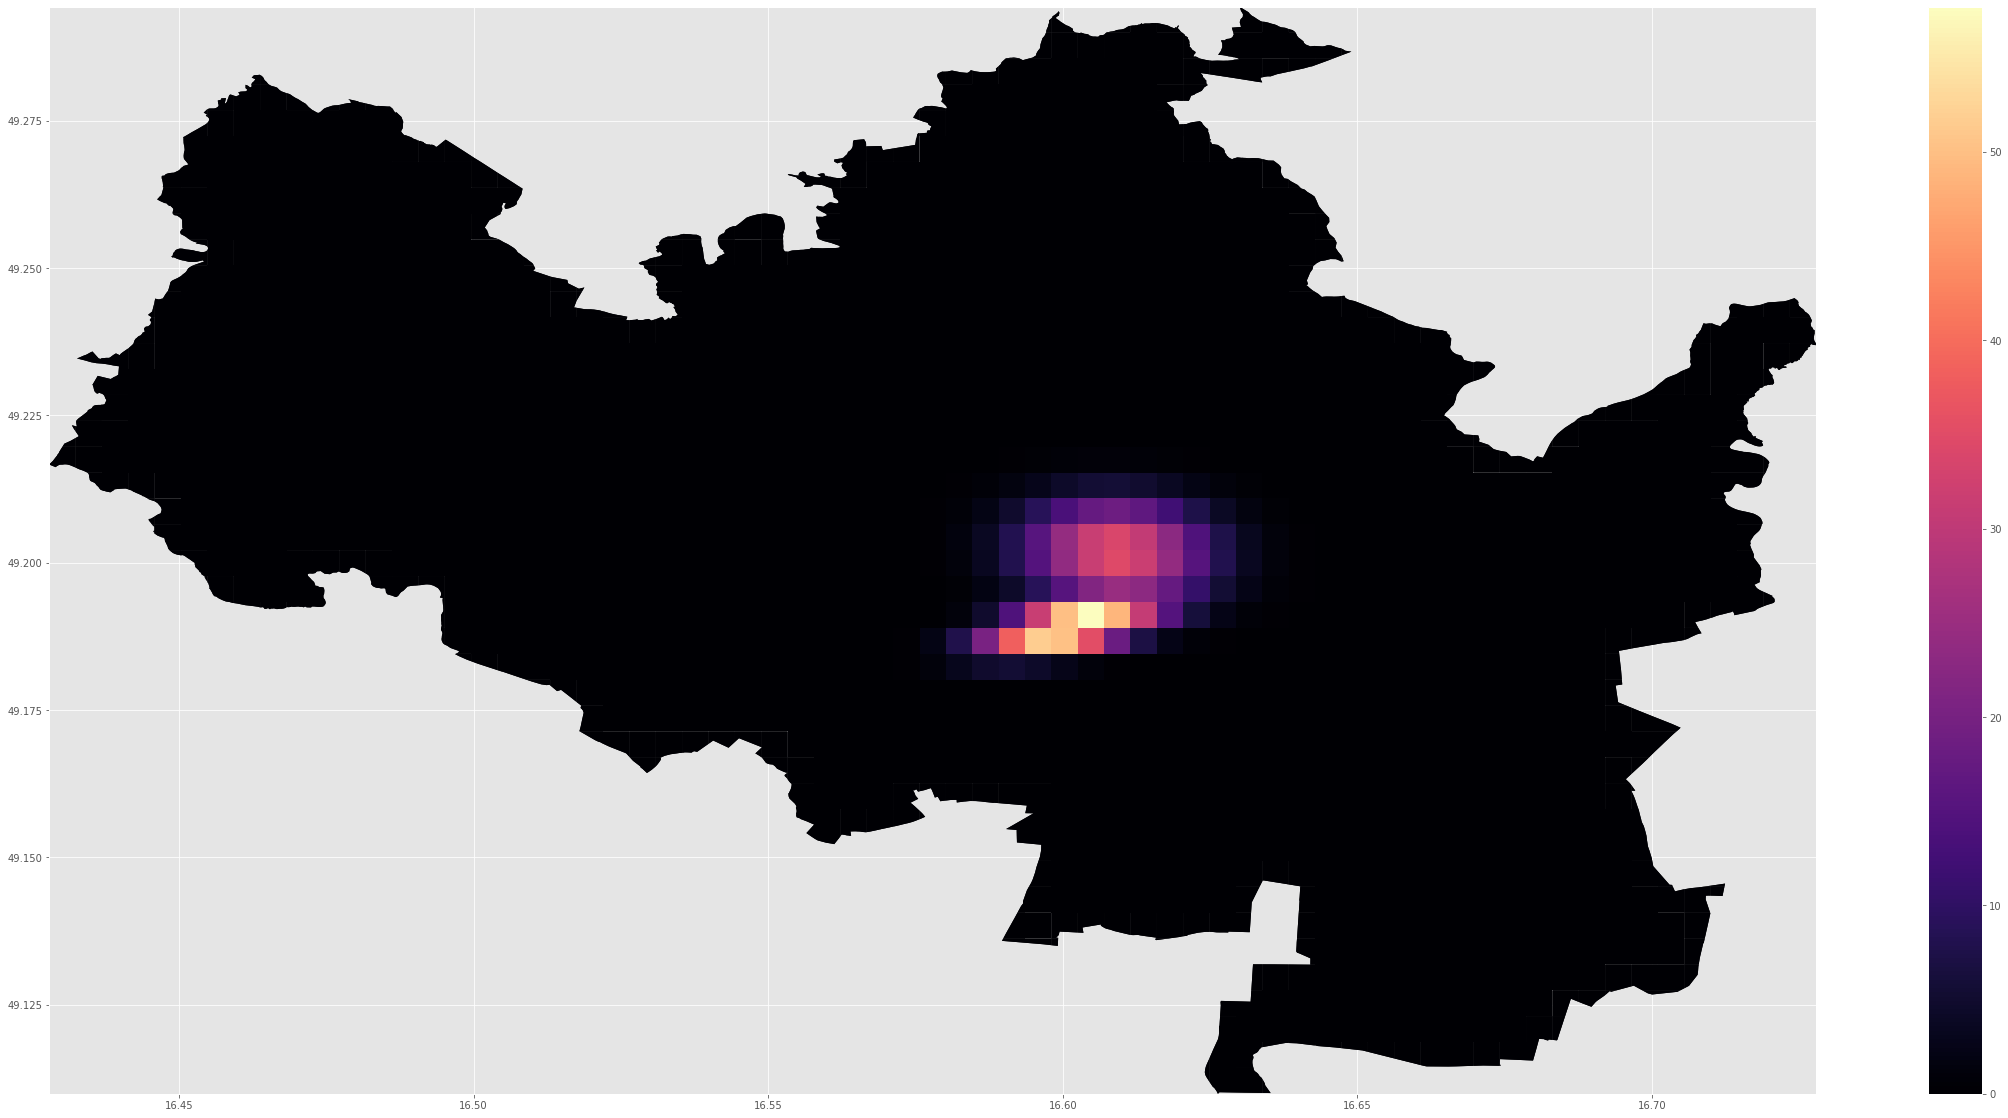

time: 1.34 s


In [12]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [13]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Brno'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Brno'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Brno'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

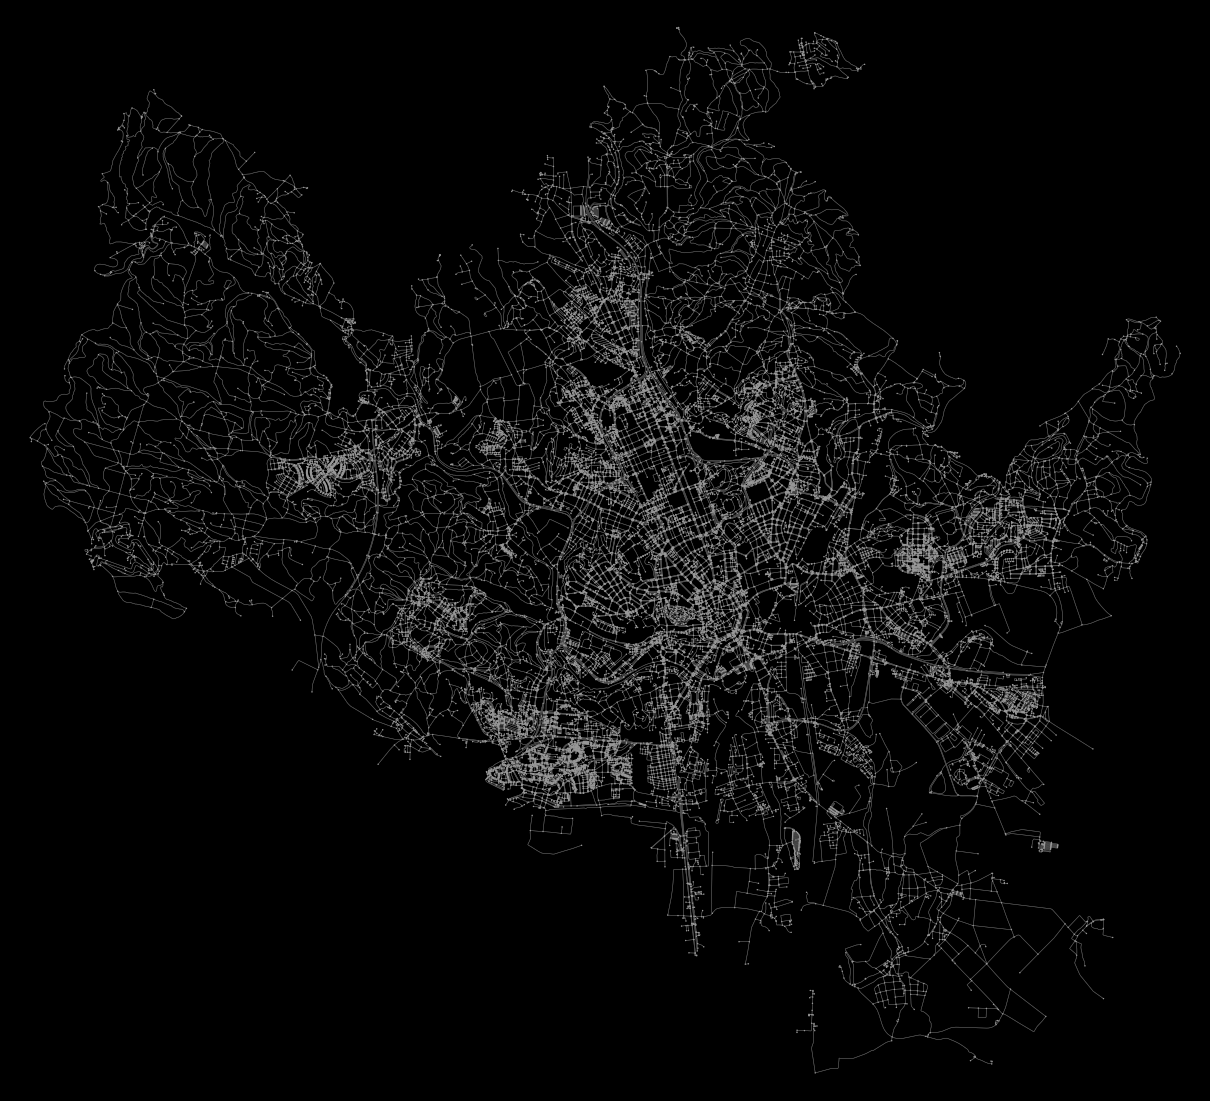

time: 1min 25s


In [14]:
# download and project a street network
G = ox.graph_from_place('Brno, Czech Republic', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [15]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 403892795, 'center_node_2': 650157589}

time: 153 ms


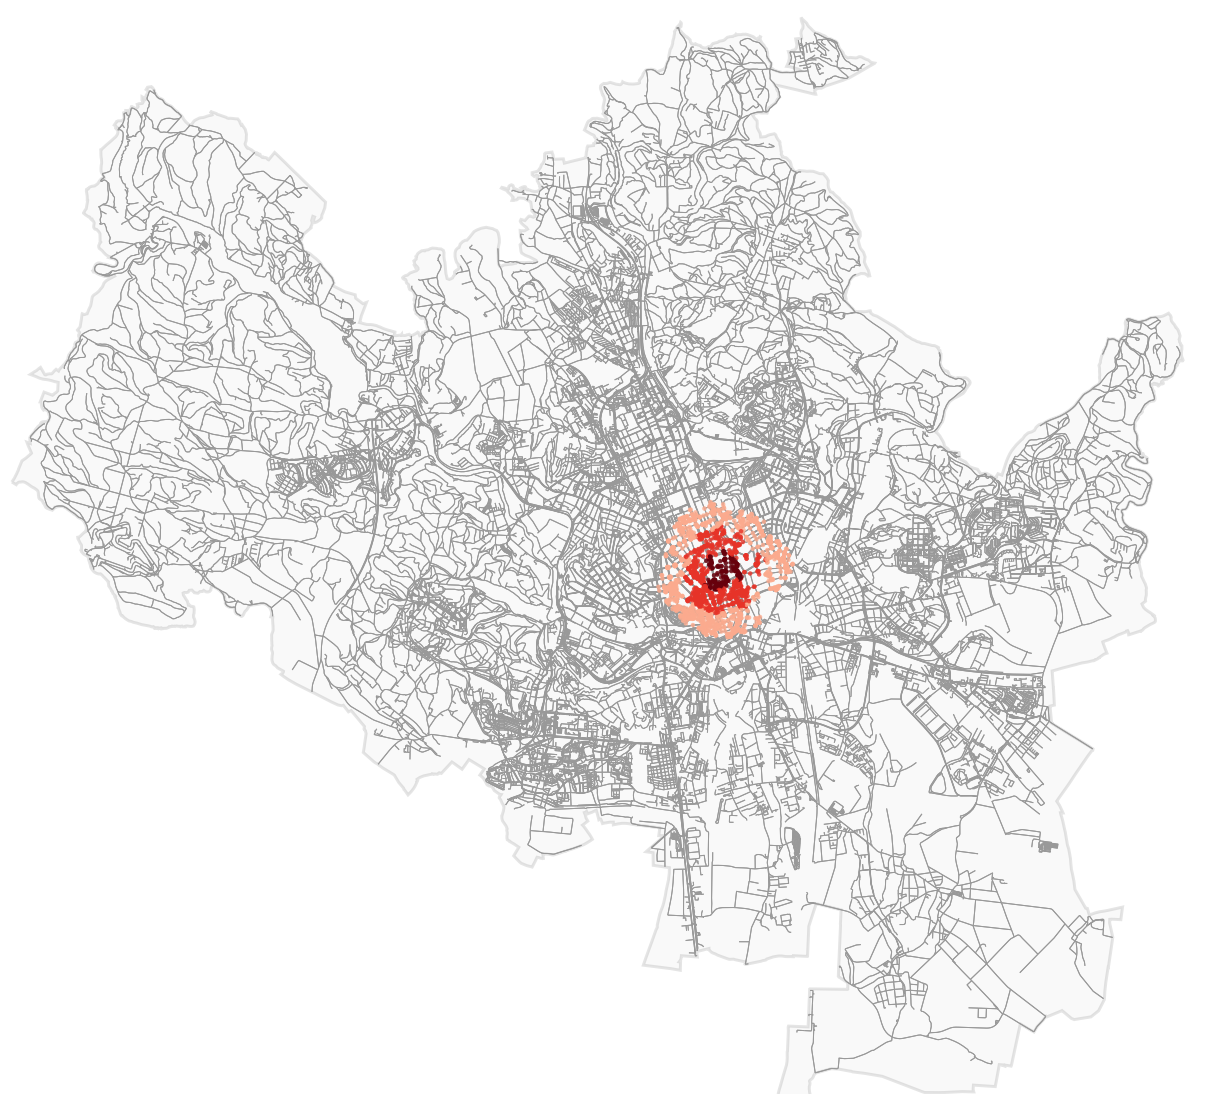

time: 19.3 s


In [16]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

1630
1630 66
Number of cells with price above 5th percentile:  66



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


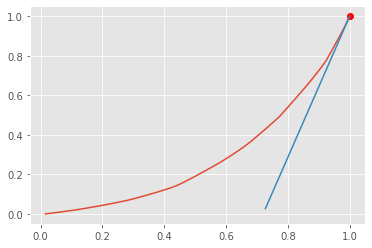

Loubar price:  23.798329728422694
Average price:  17.563898041208898
average city distance:  2231.9772664038364
eta =  0.6325734114218551
time: 1.19 s


In [17]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [18]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Brno'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 9.01 ms


In [19]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Brno'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345}

time: 7.98 ms


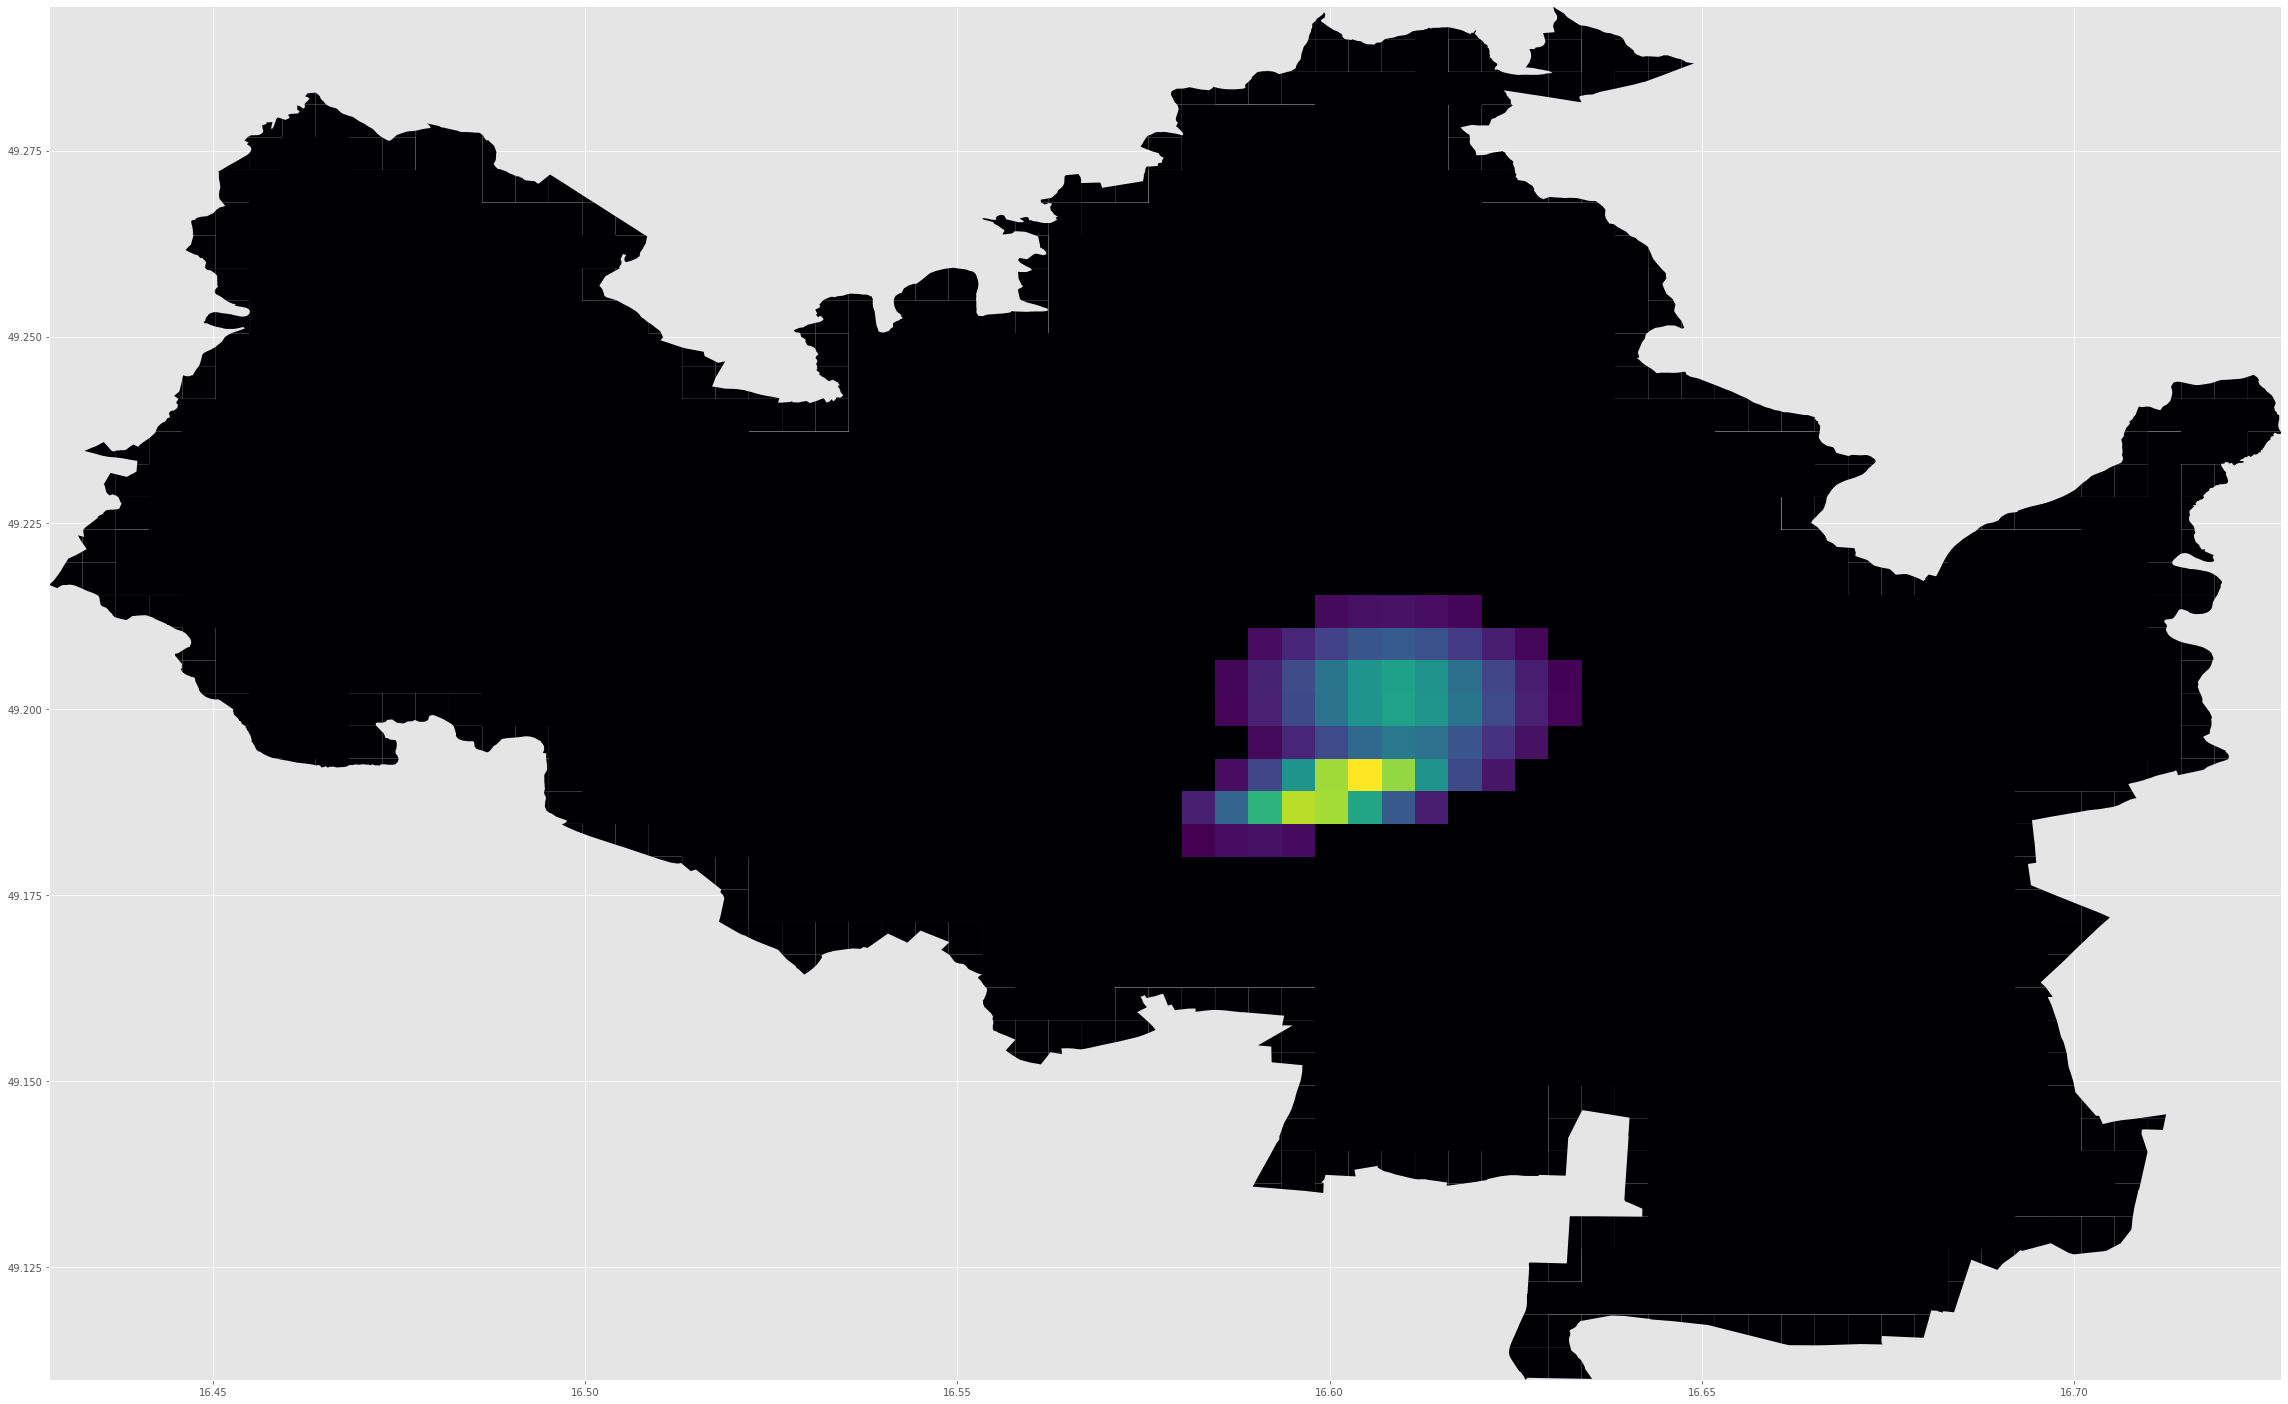

time: 1.07 s


In [20]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [21]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

1630
97



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 1.06 s


1630


1630 97
Number of cells with price above 1.0th percentile:  97
Loubar price:  16.60749361528804
Average price:  12.400630964053192
eta =  0.5747608954799766
1630 84
Number of cells with price above 2.0th percentile:  84
Loubar price:  18.69738872045965
Average price:  14.193035967696668
eta =  0.5878714954027604
1630 75
Number of cells with price above 3.0th percentile:  75
Loubar price:  21.44855248516827
Average price:  15.735561278959644
eta =  0.6048167310552806
1630 70
Number of cells with price above 4.0th percentile:  70
Loubar price:  23.189989380630173
Average price:  16.706731551920328
eta =  0.6141512407672994
1630 66
Number of cells with price above 5.0th percentile:  66
Loubar price:  23.798329728422694
Average price:  17.563898041208898
eta =  0.6325734114218551
1630 64
Number of cells with price above 6.000000000000001th percentile:  64
Loubar price:  24.077649259880186
Average price:  18.015334322465517
eta =  0.6326032146215156
1630 59
Number of cells with price above 

eta =  0.4771176773009055
1630 15
Number of cells with price above 52.0th percentile:  15
Loubar price:  48.781369668181604
Average price:  39.14706271897294
eta =  0.4771176773009055
1630 15
Number of cells with price above 53.0th percentile:  15
Loubar price:  48.781369668181604
Average price:  39.14706271897294
eta =  0.4771176773009055
1630 13
Number of cells with price above 54.0th percentile:  13
Loubar price:  49.9042662812947
Average price:  40.45387925776346
eta =  0.5788534896880544
1630 9
Number of cells with price above 55.00000000000001th percentile:  9
Loubar price:  50.23746092260669
Average price:  44.47243096053495
eta =  0.8804763133170302
1630 9
Number of cells with price above 56.00000000000001th percentile:  9
Loubar price:  50.23746092260669
Average price:  44.47243096053495
eta =  0.8804763133170302
1630 9
Number of cells with price above 57.00000000000001th percentile:  9
Loubar price:  50.23746092260669
Average price:  44.47243096053495
eta =  0.880476313317030

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
1630 7
Number of cells with price above 61.0th percentile:  7
Loubar price:  51.72147330834095
Average price:  47.40423165454519
eta =  nan
1630 6
Number of cells with price above 62.0th percentile:  6
Loubar price:  51.72147330834095
Average price:  49.43401544624718
eta =  nan
1630 6
Number of cells with price above 63.0th percentile:  6
Loubar price:  51.72147330834095
Average price:  49.43401544624718
eta =  nan
1630 6
Number of cells with price above 64.0th percentile:  6
Loubar price:  51.72147330834095
Average price:  49.43401544624718
eta =  nan
1630 6
Number of cells with price above 65.0th percentile:  6
Loubar price:  51.72147330834095
Average price:  49.43401544624718
eta =  nan
1630 6
Number of cells with price above 66.0th percentile:  6
Loubar price:  51.72147330834095
Average price:  49.43401544624718
eta =  nan
1630 5
Number of cells with price above 67.0th percentile:  5
Loubar price:  51.72147330834095
Average price:  51.66895017951185
eta =  nan
1630 5
Nu

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 91.0th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 92.0th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 93.0th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 94.0th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 95.0th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 96.00000000000001th percentile:  1
Loubar price:  57.7001807171353
Average price:  57.7001807171353
eta =  nan
1630 1
Number of cells with price above 97.0th percentile:  1
Loubar price:  57.700

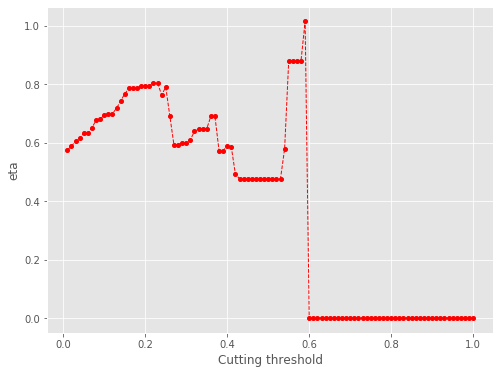

time: 1.79 s


In [22]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [23]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Brno'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 37 ms


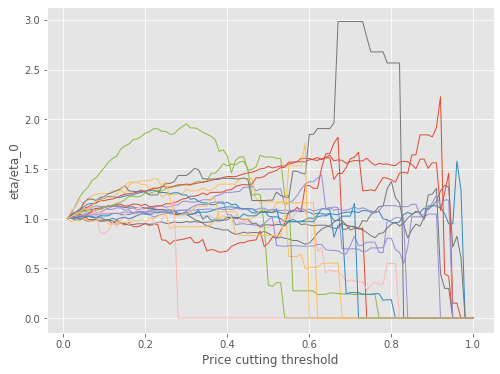

time: 212 ms


In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

1630 66
Number of cells with price above 5th percentile:  66


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9668898024982667
eta =  0.9307056292979853
eta =  0.9219412306527409
eta =  0.8857474849599679
eta =  0.8555882635282241
eta =  0.8493974754081525
eta =  0.8493974754081525
eta =  0.8223248790810876
eta =  0.7757860183338227
eta =  0.7671583536749216
eta =  0.7602321302454379
eta =  0.7602321302454379
eta =  0.7602321302454379
eta =  0.7520256359911656
eta =  0.7520256359911656
eta =  0.7520256359911656
eta =  0.7430469075563914
eta =  0.7430469075563914
eta =  0.7386693282911484
eta =  0.7137800882172973
eta =  0.707217843124739
eta =  0.6930374798599302
eta =  0.6930374798599302
eta =  0.6843134575459482
eta =  0.6843134575459482
eta =  0.6727983111393704
eta =  0.6727194229312863
eta =  0.6632900728352924
eta =  0.6632900728352924
eta =  0.6221292444473245
eta =  0.6221292444473245
eta =  0.6379577584896309
eta =  0.6379577584896309
eta =  0.6379577584896309
eta =  0.6252391787771028
eta =  0.6325734114218551

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



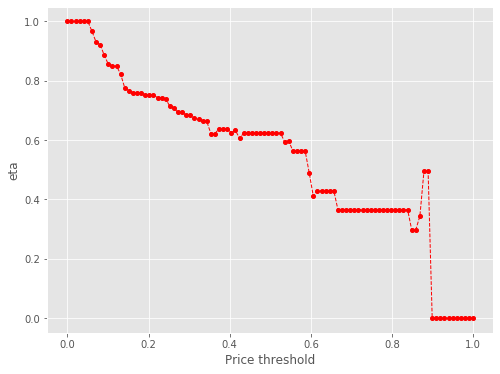

time: 524 ms


In [25]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [26]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Brno'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 25 ms


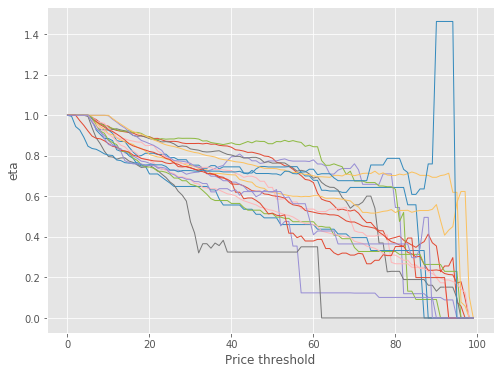

time: 208 ms


In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

1630 97
Number of cells with price above 1.0th percentile:  97


eta =  1.0
eta =  0.9431404678017217
eta =  0.885931734959948
eta =  0.8550725847050833
eta =  0.8399088007726112
eta =  0.8120992544955861
eta =  0.7817078489759892
eta =  0.774346553420369
eta =  0.7439471078800831
eta =  0.7186161123751116
eta =  0.7134164149493448
eta =  0.7134164149493448
eta =  0.7004611410823545
eta =  0.65158950431492
eta =  0.6443430528377941
eta =  0.6385256568232534
eta =  0.6385256568232534
eta =  0.6385256568232534
eta =  0.6316329500756002
eta =  0.6316329500756002
eta =  0.6316329500756002
eta =  0.6240916370434859
eta =  0.6240916370434859
eta =  0.6204148696925287
eta =  0.5995101779099589
eta =  0.594723529975708
eta =  0.5820882785996268
eta =  0.5820882785996268
eta =  0.5747608954799766
eta =  0.5747608954799766
eta =  0.5650892226709067
eta =  0.5650229637706597
eta =  0.5571031696394684
eta =  0.5571031696394684
eta =  0.5571031696394684
eta =  0.522531827629323
eta =  0.522531827629323
eta =  0.535826335876609
eta =  0.535826335876609
eta =  0.5

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


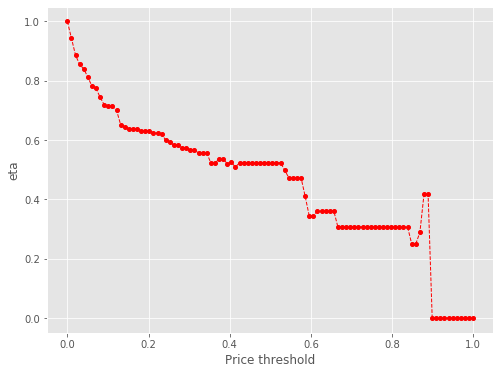

1630 84
Number of cells with price above 2.0th percentile:  84


eta =  1.0
eta =  0.934860977712106
eta =  0.9077441889203373
eta =  0.8862962367126217
eta =  0.8611405901447272
eta =  0.8248808967340567
eta =  0.8171130431977275
eta =  0.7850346625976891
eta =  0.7618156023193007
eta =  0.7528177859274472
eta =  0.7528177859274472
eta =  0.7515232981768385
eta =  0.7019042507269443
eta =  0.6799295618247335
eta =  0.6737908760645512
eta =  0.6737908760645512
eta =  0.6737908760645512
eta =  0.666517491090386
eta =  0.666517491090386
eta =  0.666517491090386
eta =  0.6585596778681809
eta =  0.6585596778681809
eta =  0.6546798458394849
eta =  0.6451516896268453
eta =  0.6326206060273938
eta =  0.6211383957338459
eta =  0.6142365103006555
eta =  0.6142365103006555
eta =  0.6065044421547764
eta =  0.5962986112294315
eta =  0.5962286929074856
eta =  0.5878714954027604
eta =  0.5878714954027604
eta =  0.5878714954027604
eta =  0.5513908081025304
eta =  0.5513908081025304
eta =  0.5654195605309794
eta =  0.5654195605309794
eta =  0.5654195605309794
eta =

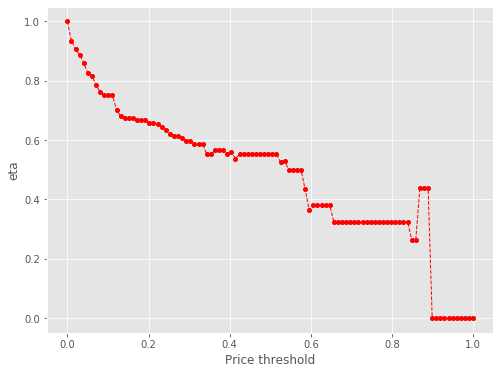

1630 75
Number of cells with price above 3.0th percentile:  75


eta =  1.0
eta =  0.953101961702254
eta =  0.9329454373785063
eta =  0.9044879198140101
eta =  0.8823567529289708
eta =  0.8740476527295598
eta =  0.8397341223065186
eta =  0.8111416309153882
eta =  0.8052724457168222
eta =  0.8052724457168222
eta =  0.7906491137424054
eta =  0.7508113692420033
eta =  0.7273055331593062
eta =  0.7207391175033597
eta =  0.7207391175033597
eta =  0.7207391175033597
eta =  0.7129589393297392
eta =  0.7129589393297392
eta =  0.7129589393297392
eta =  0.7044466434783493
eta =  0.7044466434783493
eta =  0.7002964734304015
eta =  0.6901044166007775
eta =  0.6767001951195055
eta =  0.6644179300904866
eta =  0.6570351367150679
eta =  0.6570351367150679
eta =  0.6487643153520862
eta =  0.6378473649512666
eta =  0.6377725748770064
eta =  0.6288330665394376
eta =  0.6288330665394376
eta =  0.6288330665394376
eta =  0.5898104865302586
eta =  0.5898104865302586
eta =  0.6048167310552806
eta =  0.6048167310552806
eta =  0.6048167310552806
eta =  0.5927588640522848
et

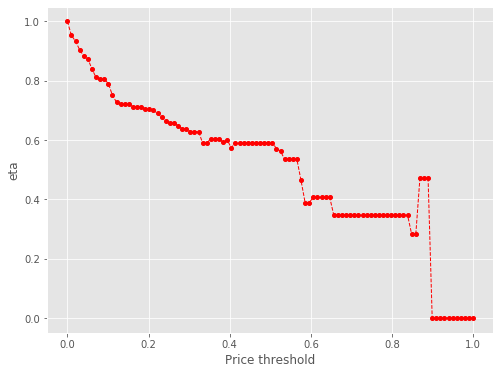

1630 70
Number of cells with price above 4.0th percentile:  70


eta =  1.0
eta =  0.9822660857058093
eta =  0.9543865376900182
eta =  0.9142005754348941
eta =  0.9055916038840646
eta =  0.8700397149753929
eta =  0.8443064505106641
eta =  0.8343343333775624
eta =  0.8343343333775624
eta =  0.8328996760213484
eta =  0.7779077833604503
eta =  0.7535536331807782
eta =  0.7467502388039753
eta =  0.7467502388039753
eta =  0.7467502388039753
eta =  0.7467502388039753
eta =  0.738689277815464
eta =  0.738689277815464
eta =  0.7298697773812228
eta =  0.7298697773812228
eta =  0.7298697773812228
eta =  0.7255698297314858
eta =  0.7011219733079519
eta =  0.6946761025074425
eta =  0.6807472125894324
eta =  0.6807472125894324
eta =  0.6721779013394671
eta =  0.6721779013394671
eta =  0.6608669635523485
eta =  0.6607894743409854
eta =  0.6515273435314438
eta =  0.6515273435314438
eta =  0.6515273435314438
eta =  0.6110964577463861
eta =  0.6110964577463861
eta =  0.6266442702772618
eta =  0.6266442702772618
eta =  0.6089731532582897
eta =  0.6141512407672994
eta

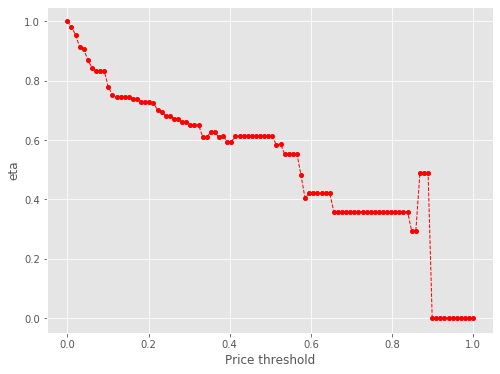

1630 66
Number of cells with price above 5.0th percentile:  66


eta =  1.0
eta =  0.9668898024982667
eta =  0.9307056292979853
eta =  0.9219412306527409
eta =  0.8857474849599679
eta =  0.8595496299803387
eta =  0.8493974754081525
eta =  0.8493974754081525
eta =  0.8479369166277044
eta =  0.7919521957245251
eta =  0.7671583536749216
eta =  0.7602321302454379
eta =  0.7602321302454379
eta =  0.7602321302454379
eta =  0.7602321302454379
eta =  0.7520256359911656
eta =  0.7520256359911656
eta =  0.7430469075563914
eta =  0.7430469075563914
eta =  0.7430469075563914
eta =  0.7386693282911484
eta =  0.7137800882172973
eta =  0.707217843124739
eta =  0.6930374798599302
eta =  0.6930374798599302
eta =  0.6843134575459482
eta =  0.6843134575459482
eta =  0.6727983111393704
eta =  0.6727194229312863
eta =  0.6632900728352924
eta =  0.6632900728352924
eta =  0.6632900728352924
eta =  0.6221292444473245
eta =  0.6221292444473245
eta =  0.6379577584896309
eta =  0.6379577584896309
eta =  0.6379577584896309
eta =  0.6252391787771028
eta =  0.6325734114218551
et

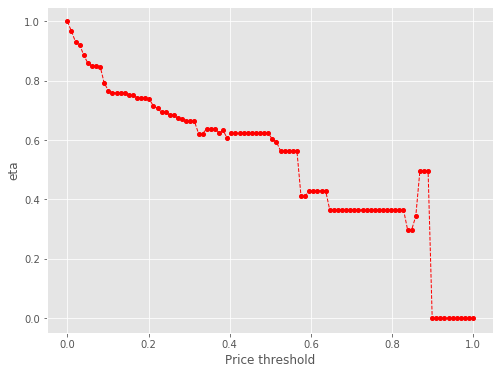

1630 64
Number of cells with price above 6.000000000000001th percentile:  64


eta =  1.0
eta =  0.9578934104074963
eta =  0.9488729860711822
eta =  0.9116219483577619
eta =  0.8846588014057803
eta =  0.8742100820040607
eta =  0.8742100820040607
eta =  0.8727068573675456
eta =  0.8199901496823898
eta =  0.7895685903163169
eta =  0.7814124463210882
eta =  0.7824400379864929
eta =  0.7824400379864929
eta =  0.7824400379864929
eta =  0.7739938155491753
eta =  0.7739938155491753
eta =  0.7739938155491753
eta =  0.764752800419616
eta =  0.764752800419616
eta =  0.7602473432699954
eta =  0.7346310384940427
eta =  0.7346310384940427
eta =  0.713282496877106
eta =  0.713282496877106
eta =  0.7043036283458017
eta =  0.7043036283458017
eta =  0.6924521013801183
eta =  0.692370908688999
eta =  0.68266610833425
eta =  0.68266610833425
eta =  0.68266610833425
eta =  0.6403028894618255
eta =  0.6403028894618255
eta =  0.6565937861969233
eta =  0.6565937861969233
eta =  0.6565937861969233
eta =  0.638078104844436
eta =  0.6435036712208674
eta =  0.6234083993233117
eta =  0.6417

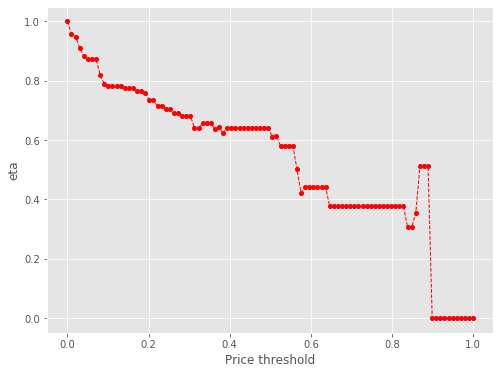

1630 59
Number of cells with price above 6.999999999999999th percentile:  59


eta =  1.0
eta =  0.9556475120223733
eta =  0.9516945606400506
eta =  0.9192898770512209
eta =  0.9126381625614942
eta =  0.9126381625614942
eta =  0.8835499143820078
eta =  0.8335460686092382
eta =  0.8242760433861086
eta =  0.8168341377916318
eta =  0.8168341377916318
eta =  0.8168341377916318
eta =  0.808016640619661
eta =  0.808016640619661
eta =  0.808016640619661
eta =  0.7983694136639727
eta =  0.7983694136639727
eta =  0.7983694136639727
eta =  0.7936659079287116
eta =  0.7669235747028724
eta =  0.7598727469373757
eta =  0.7446366047905782
eta =  0.7446366047905782
eta =  0.7352630477395025
eta =  0.7352630477395025
eta =  0.7228905574008939
eta =  0.722805795682902
eta =  0.7126743966678275
eta =  0.7126743966678275
eta =  0.7126743966678275
eta =  0.6684489970438725
eta =  0.6684489970438725
eta =  0.6854560007022102
eta =  0.6854560007022102
eta =  0.6854560007022102
eta =  0.6717904771336879
eta =  0.6717904771336879
eta =  0.6508118675313868
eta =  0.6699880433001931
eta =

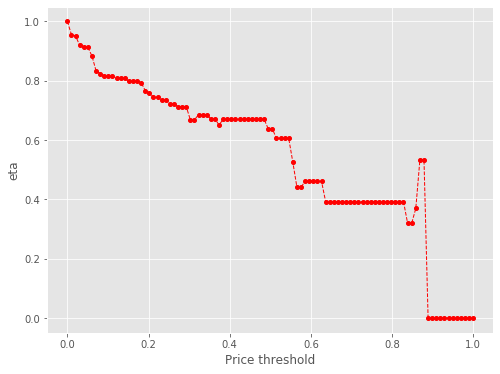

1630 56
Number of cells with price above 8.0th percentile:  56


eta =  1.0
eta =  0.9607418081658551
eta =  0.9280290707060163
eta =  0.9213141219498048
eta =  0.9213141219498048
eta =  0.9197299008173863
eta =  0.8590050747202371
eta =  0.8321119917066384
eta =  0.8245993399245071
eta =  0.8245993399245071
eta =  0.8245993399245071
eta =  0.8245993399245071
eta =  0.815698019556763
eta =  0.815698019556763
eta =  0.815698019556763
eta =  0.8059590816112095
eta =  0.8059590816112095
eta =  0.8012108621806243
eta =  0.7895501057015065
eta =  0.774214303998462
eta =  0.7601621353430543
eta =  0.7517154638688356
eta =  0.7517154638688356
eta =  0.7422527974602562
eta =  0.7297626885208555
eta =  0.7296771210188704
eta =  0.7296771210188704
eta =  0.7194494082509775
eta =  0.7194494082509775
eta =  0.7194494082509775
eta =  0.6748035815762927
eta =  0.6748035815762927
eta =  0.6919722616570172
eta =  0.6919722616570172
eta =  0.6919722616570172
eta =  0.6781768273173215
eta =  0.6861320335722361
eta =  0.6569987853743632
eta =  0.6763572587163132
eta =

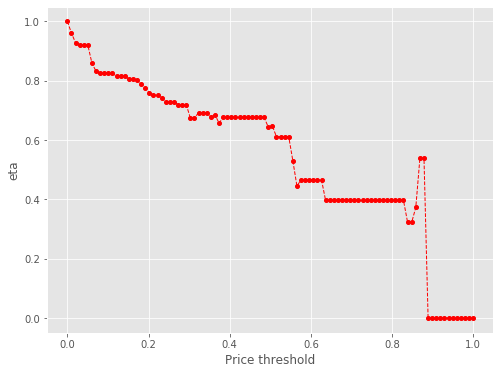

1630 52
Number of cells with price above 9.0th percentile:  52


eta =  1.0
eta =  0.9659505424019275
eta =  0.9589612048929969
eta =  0.9589612048929969
eta =  0.9415469643780937
eta =  0.8758546103790348
eta =  0.8661140637724689
eta =  0.8582944271976083
eta =  0.8582944271976083
eta =  0.8582944271976083
eta =  0.8582944271976083
eta =  0.8490293777409417
eta =  0.8490293777409417
eta =  0.8388924836630769
eta =  0.8388924836630769
eta =  0.8388924836630769
eta =  0.8339502407105712
eta =  0.8058505390501416
eta =  0.8058505390501416
eta =  0.7824323428829749
eta =  0.7824323428829749
eta =  0.7824323428829749
eta =  0.7725830094531697
eta =  0.7595825250012175
eta =  0.759493461007897
eta =  0.759493461007897
eta =  0.7488478196077184
eta =  0.7488478196077184
eta =  0.7488478196077184
eta =  0.7023776584309942
eta =  0.7023776584309942
eta =  0.720247891551692
eta =  0.720247891551692
eta =  0.720247891551692
eta =  0.7058887430037252
eta =  0.7141690178780973
eta =  0.6838453159737418
eta =  0.7039948225086007
eta =  0.7039948225086007
eta = 

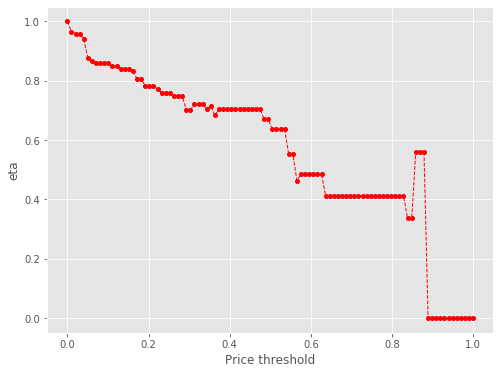

1630 48
Number of cells with price above 10.0th percentile:  48


eta =  1.0
eta =  0.992764290507513
eta =  0.9910572091429031
eta =  0.9611222057792531
eta =  0.9067282142635785
eta =  0.8966443164044344
eta =  0.8885490400609725
eta =  0.8885490400609725
eta =  0.8885490400609725
eta =  0.8789574004790657
eta =  0.8789574004790657
eta =  0.8789574004790657
eta =  0.8684631840229535
eta =  0.8684631840229535
eta =  0.8684631840229535
eta =  0.8633467285363028
eta =  0.8342565210909432
eta =  0.8342565210909432
eta =  0.8100128407582678
eta =  0.8100128407582678
eta =  0.8100128407582678
eta =  0.7998163213740415
eta =  0.786357573869614
eta =  0.7862653703981
eta =  0.7862653703981
eta =  0.7752444734340512
eta =  0.7752444734340512
eta =  0.7752444734340512
eta =  0.7271362534612441
eta =  0.7271362534612441
eta =  0.7456364067675011
eta =  0.7456364067675011
eta =  0.7456364067675011
eta =  0.7307711026782655
eta =  0.7393432546787007
eta =  0.7079506516692828
eta =  0.7288104220719738
eta =  0.7288104220719738
eta =  0.7288104220719738
eta =  0.

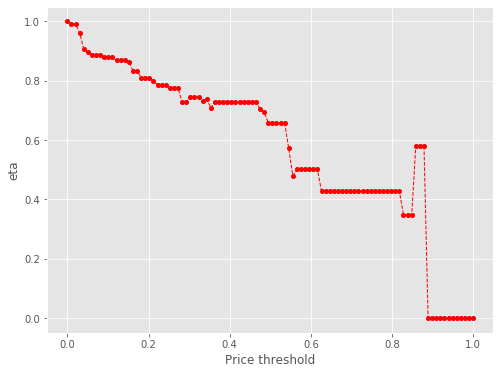

1630 47
Number of cells with price above 11.0th percentile:  47


eta =  1.0
eta =  0.9681272936276908
eta =  0.9133368544108775
eta =  0.9031794606009238
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8853636345337644
eta =  0.8853636345337644
eta =  0.8853636345337644
eta =  0.8747929315416701
eta =  0.8747929315416701
eta =  0.8696391850425538
eta =  0.8696391850425538
eta =  0.8403369551743861
eta =  0.8419158591670376
eta =  0.8159165760728355
eta =  0.8159165760728355
eta =  0.805645739901831
eta =  0.805645739901831
eta =  0.7920888990352571
eta =  0.7919960235436668
eta =  0.7808948013608921
eta =  0.7808948013608921
eta =  0.7808948013608921
eta =  0.7324359471970163
eta =  0.7324359471970163
eta =  0.7324359471970163
eta =  0.751070937882267
eta =  0.751070937882267
eta =  0.751070937882267
eta =  0.7360972888183624
eta =  0.7447319184906818
eta =  0.7131105121713937
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.7

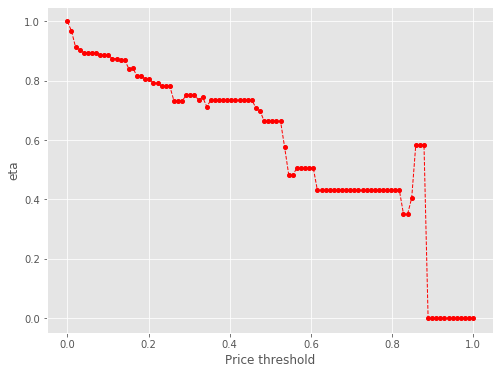

1630 47
Number of cells with price above 12.0th percentile:  47


eta =  1.0
eta =  0.9681272936276908
eta =  0.9133368544108775
eta =  0.9031794606009238
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8950251822683263
eta =  0.8853636345337644
eta =  0.8853636345337644
eta =  0.8853636345337644
eta =  0.8747929315416701
eta =  0.8747929315416701
eta =  0.8696391850425538
eta =  0.8696391850425538
eta =  0.8403369551743861
eta =  0.8419158591670376
eta =  0.8159165760728355
eta =  0.8159165760728355
eta =  0.805645739901831
eta =  0.805645739901831
eta =  0.7920888990352571
eta =  0.7919960235436668
eta =  0.7808948013608921
eta =  0.7808948013608921
eta =  0.7808948013608921
eta =  0.7324359471970163
eta =  0.7324359471970163
eta =  0.7324359471970163
eta =  0.751070937882267
eta =  0.751070937882267
eta =  0.751070937882267
eta =  0.7360972888183624
eta =  0.7447319184906818
eta =  0.7131105121713937
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.734122317896222
eta =  0.7

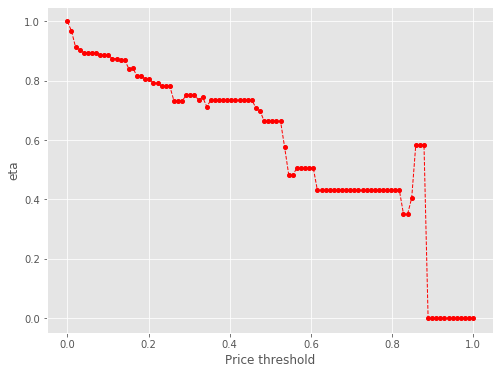

1630 45
Number of cells with price above 13.0th percentile:  45


eta =  1.0
eta =  0.9496138757282143
eta =  0.9198840807102496
eta =  0.9115789861470426
eta =  0.9115789861470426
eta =  0.9115789861470426
eta =  0.9115789861470426
eta =  0.90173874470695
eta =  0.90173874470695
eta =  0.90173874470695
eta =  0.8909725328647607
eta =  0.8909725328647607
eta =  0.8909725328647607
eta =  0.8857234660210584
eta =  0.8558792811598286
eta =  0.8480106256658921
eta =  0.8310072386031041
eta =  0.8310072386031041
eta =  0.8205464397237717
eta =  0.8205464397237717
eta =  0.8067388603423871
eta =  0.8066442670860865
eta =  0.7953377239151782
eta =  0.7953377239151782
eta =  0.7953377239151782
eta =  0.7953377239151782
eta =  0.7459826062897728
eta =  0.7459826062897728
eta =  0.7649622576473674
eta =  0.7649622576473674
eta =  0.7649622576473674
eta =  0.7497116657053592
eta =  0.7497116657053592
eta =  0.7262997405821728
eta =  0.7262997405821728
eta =  0.7477001670050523
eta =  0.7477001670050523
eta =  0.7477001670050523
eta =  0.7477001670050523
eta =  

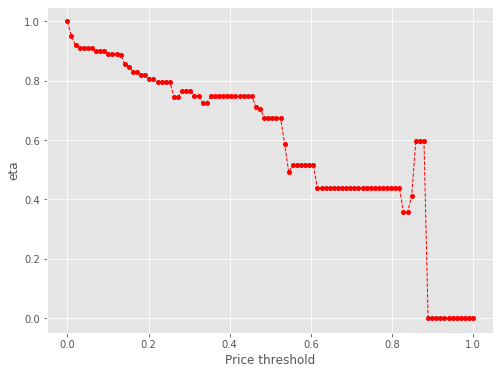

1630 42
Number of cells with price above 14.000000000000002th percentile:  42


eta =  1.0
eta =  0.9686927542047905
eta =  0.9599469947171901
eta =  0.9599469947171901
eta =  0.9599469947171901
eta =  0.9599469947171901
eta =  0.9495846340866164
eta =  0.9495846340866164
eta =  0.9495846340866164
eta =  0.9382471714427254
eta =  0.9382471714427254
eta =  0.9382471714427254
eta =  0.9327195912568556
eta =  0.9012918861400324
eta =  0.8930057230004065
eta =  0.8751001431669726
eta =  0.8751001431669726
eta =  0.8640842985729681
eta =  0.8640842985729681
eta =  0.8495440946708334
eta =  0.8494444823350006
eta =  0.8494444823350006
eta =  0.8375380186028464
eta =  0.8375380186028464
eta =  0.8375380186028464
eta =  0.7855641386007693
eta =  0.7855641386007693
eta =  0.8055508425050695
eta =  0.8055508425050695
eta =  0.8055508425050695
eta =  0.7828346319246388
eta =  0.789491060385402
eta =  0.7761176898450597
eta =  0.7648369080803581
eta =  0.7873728323858749
eta =  0.7873728323858749
eta =  0.7873728323858749
eta =  0.7873728323858749
eta =  0.7873728323858749
et

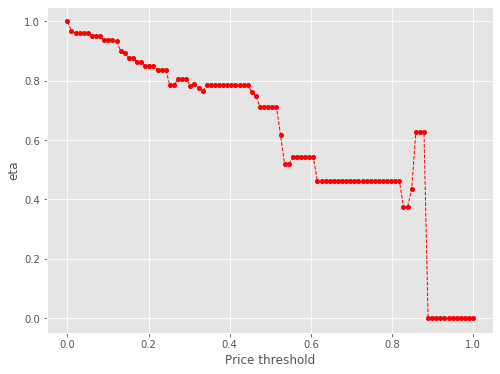

1630 40
Number of cells with price above 15.000000000000002th percentile:  40


eta =  1.0
eta =  0.9909715857276337
eta =  0.9909715857276337
eta =  0.9909715857276337
eta =  0.9802743232720263
eta =  0.9802743232720263
eta =  0.9802743232720263
eta =  0.9685704444160333
eta =  0.9685704444160333
eta =  0.9685704444160333
eta =  0.962864217997103
eta =  0.9488507719762111
eta =  0.9304207987804263
eta =  0.9135334461218172
eta =  0.9033825631176017
eta =  0.9033825631176017
eta =  0.8920106967067214
eta =  0.8920106967067214
eta =  0.8770005669839376
eta =  0.8768977352703726
eta =  0.8646064657419572
eta =  0.8646064657419572
eta =  0.8646064657419572
eta =  0.8646064657419572
eta =  0.8109528384422022
eta =  0.8109528384422022
eta =  0.8315854939643418
eta =  0.8315854939643418
eta =  0.8315854939643418
eta =  0.8150066746741623
eta =  0.8150066746741623
eta =  0.789555723174806
eta =  0.789555723174806
eta =  0.812819987522501
eta =  0.812819987522501
eta =  0.812819987522501
eta =  0.812819987522501
eta =  0.812819987522501
eta =  0.812819987522501
eta =  0.8

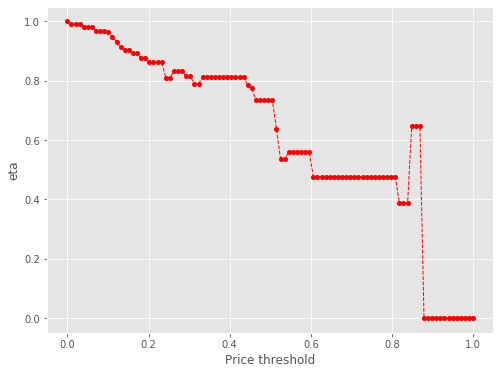

1630 38
Number of cells with price above 16.0th percentile:  38


eta =  1.0
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9716365553408955
eta =  0.9388975548650598
eta =  0.9314011482867165
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9001375110586557
eta =  0.9001375110586557
eta =  0.8849906290098001
eta =  0.8848868604305129
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8183411614640289
eta =  0.8183411614640289
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8154977683484175
eta =  0.8224319308567593
eta =  0.832079290331535
eta =  0.7967491041582838
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
et

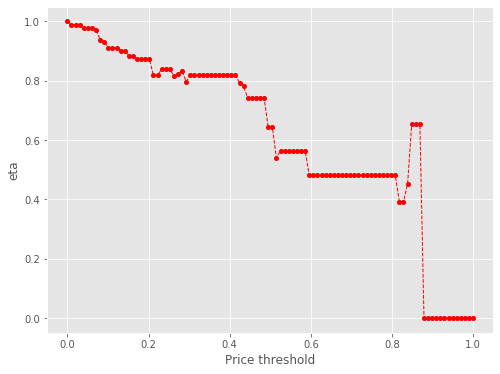

1630 38
Number of cells with price above 17.0th percentile:  38


eta =  1.0
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9716365553408955
eta =  0.9388975548650598
eta =  0.9314011482867165
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9001375110586557
eta =  0.9001375110586557
eta =  0.8849906290098001
eta =  0.8848868604305129
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8183411614640289
eta =  0.8183411614640289
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8154977683484175
eta =  0.8224319308567593
eta =  0.832079290331535
eta =  0.7967491041582838
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
et

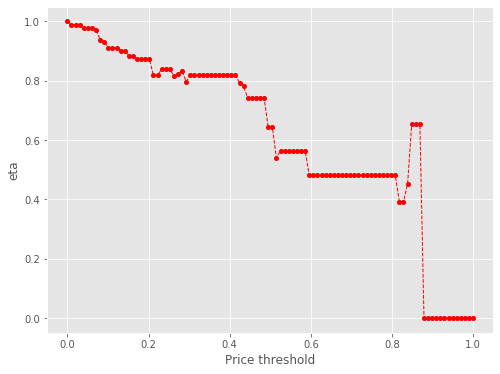

1630 38
Number of cells with price above 18.000000000000004th percentile:  38


eta =  1.0
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9892052783251573
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9773947693009261
eta =  0.9716365553408955
eta =  0.9388975548650598
eta =  0.9314011482867165
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9116129827822272
eta =  0.9001375110586557
eta =  0.9001375110586557
eta =  0.8849906290098001
eta =  0.8848868604305129
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8724836092117704
eta =  0.8183411614640289
eta =  0.8183411614640289
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8391617942846862
eta =  0.8154977683484175
eta =  0.8224319308567593
eta =  0.832079290331535
eta =  0.7967491041582838
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
eta =  0.8202253215218853
et

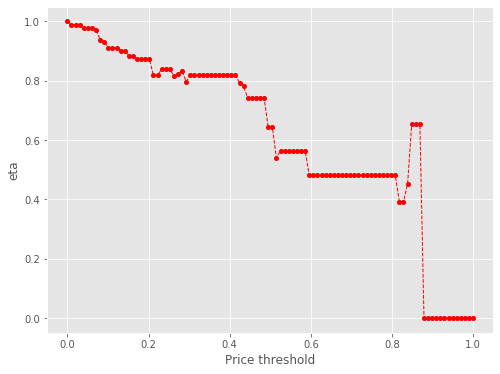

1630 37
Number of cells with price above 19.0th percentile:  37


eta =  1.0
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9822395579873899
eta =  0.9491432925375465
eta =  0.9404172002629003
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9099602790056842
eta =  0.9099602790056842
eta =  0.894648106314389
eta =  0.8945432053584793
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.8272713251688044
eta =  0.8272713251688044
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8314067351614164
eta =  0.8314067351614164
eta =  0.8054436441213447
eta =  0.8054436441213447
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.82917604

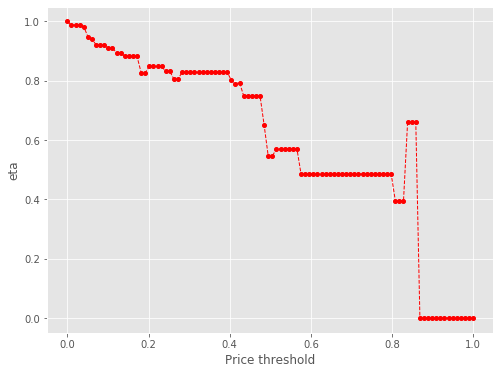

1630 37
Number of cells with price above 20.0th percentile:  37


eta =  1.0
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9822395579873899
eta =  0.9491432925375465
eta =  0.9404172002629003
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9099602790056842
eta =  0.9099602790056842
eta =  0.894648106314389
eta =  0.8945432053584793
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.8272713251688044
eta =  0.8272713251688044
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8314067351614164
eta =  0.8314067351614164
eta =  0.8054436441213447
eta =  0.8054436441213447
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.82917604

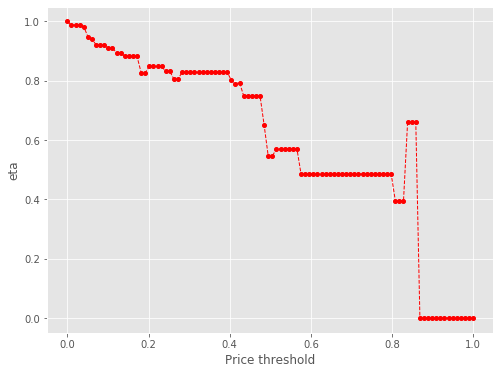

1630 37
Number of cells with price above 21.000000000000004th percentile:  37


eta =  1.0
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9880606085682965
eta =  0.9822395579873899
eta =  0.9491432925375465
eta =  0.9404172002629003
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9215609770357239
eta =  0.9099602790056842
eta =  0.9099602790056842
eta =  0.894648106314389
eta =  0.8945432053584793
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.882004603421637
eta =  0.8272713251688044
eta =  0.8272713251688044
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8483191635466072
eta =  0.8314067351614164
eta =  0.8314067351614164
eta =  0.8054436441213447
eta =  0.8054436441213447
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.829176046159625
eta =  0.82917604

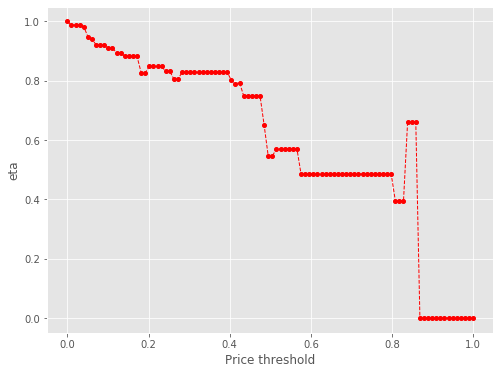

1630 36
Number of cells with price above 22.0th percentile:  36


eta =  1.0
eta =  0.9941086098054842
eta =  0.960612420236911
eta =  0.9529426364261125
eta =  0.9431770826670238
eta =  0.9326968093294087
eta =  0.9326968093294087
eta =  0.9209559323736426
eta =  0.9209559323736426
eta =  0.9054587325475281
eta =  0.9053525640038173
eta =  0.9053525640038173
eta =  0.8926624498264989
eta =  0.8926624498264989
eta =  0.8926624498264989
eta =  0.8372677930835879
eta =  0.8372677930835879
eta =  0.8372677930835879
eta =  0.8585699664475287
eta =  0.8585699664475287
eta =  0.8585699664475287
eta =  0.8343586378426149
eta =  0.8414531739769768
eta =  0.8513236580206719
eta =  0.8151763536939658
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
et

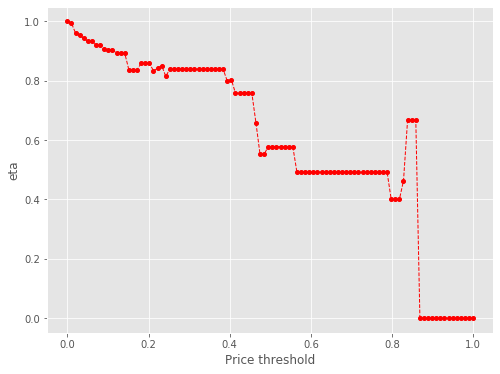

1630 36
Number of cells with price above 23.0th percentile:  36


eta =  1.0
eta =  0.9941086098054842
eta =  0.960612420236911
eta =  0.9529426364261125
eta =  0.9431770826670238
eta =  0.9326968093294087
eta =  0.9326968093294087
eta =  0.9209559323736426
eta =  0.9209559323736426
eta =  0.9054587325475281
eta =  0.9053525640038173
eta =  0.9053525640038173
eta =  0.8926624498264989
eta =  0.8926624498264989
eta =  0.8926624498264989
eta =  0.8372677930835879
eta =  0.8372677930835879
eta =  0.8372677930835879
eta =  0.8585699664475287
eta =  0.8585699664475287
eta =  0.8585699664475287
eta =  0.8343586378426149
eta =  0.8414531739769768
eta =  0.8513236580206719
eta =  0.8151763536939658
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
eta =  0.8391955300809979
et

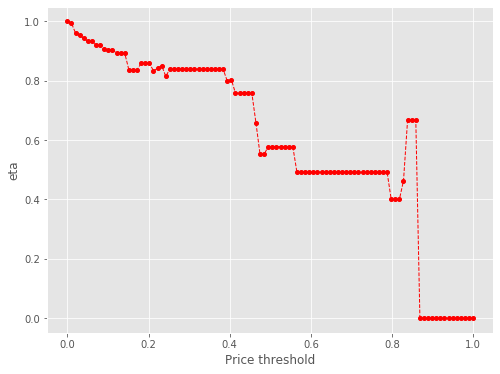

1630 35
Number of cells with price above 24.000000000000004th percentile:  35


eta =  1.0
eta =  0.9663053018169439
eta =  0.9574214280168234
eta =  0.9382242545026424
eta =  0.9382242545026424
eta =  0.9382242545026424
eta =  0.9264137975365133
eta =  0.9264137975365133
eta =  0.9108247565874094
eta =  0.9107179588565945
eta =  0.9107179588565945
eta =  0.8979526392002227
eta =  0.8979526392002227
eta =  0.8979526392002227
eta =  0.842229696861206
eta =  0.842229696861206
eta =  0.842229696861206
eta =  0.8636581133881577
eta =  0.8636581133881577
eta =  0.8636581133881577
eta =  0.8393033010808272
eta =  0.8464398815956565
eta =  0.8563688611320337
eta =  0.8200073368778791
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.8441688582148001
eta =  0.804043361894626
eta =

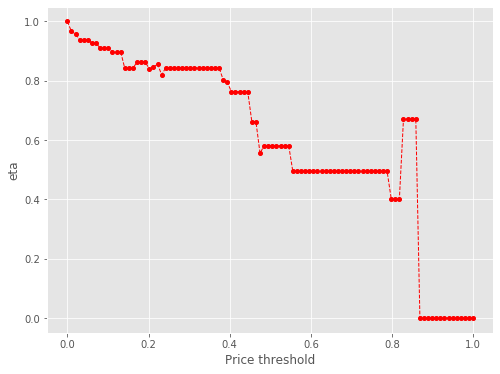

1630 33
Number of cells with price above 25.0th percentile:  33


eta =  1.0
eta =  0.9818497687489954
eta =  0.9709397772510399
eta =  0.9709397772510399
eta =  0.9587174941445291
eta =  0.9587174941445291
eta =  0.9425848692693557
eta =  0.9425848692693557
eta =  0.9424743475423051
eta =  0.9292639060468801
eta =  0.9292639060468801
eta =  0.9292639060468801
eta =  0.9292639060468801
eta =  0.8715979259117811
eta =  0.8715979259117811
eta =  0.8937735431692461
eta =  0.8937735431692461
eta =  0.8937735431692461
eta =  0.8937735431692461
eta =  0.8685694878240708
eta =  0.8759549181858938
eta =  0.8862301174606031
eta =  0.8486006806917227
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8736047050839
eta =  0.8320800479752964
eta =  0.8366633901039126
eta =  0.7898270027369048
eta =  0.78982700

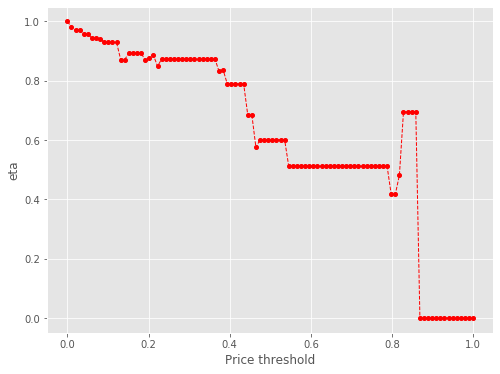

1630 32
Number of cells with price above 26.0th percentile:  32


eta =  1.0
eta =  0.9897522123727057
eta =  0.978754411521943
eta =  0.978754411521943
eta =  0.9664337570491841
eta =  0.9664337570491841
eta =  0.9501712883194453
eta =  0.9501712883194453
eta =  0.9500598770553749
eta =  0.9367431109749832
eta =  0.9367431109749832
eta =  0.9367431109749832
eta =  0.9367431109749832
eta =  0.8786130046858349
eta =  0.8786130046858349
eta =  0.9009671029805989
eta =  0.9009671029805989
eta =  0.9009671029805989
eta =  0.9009671029805989
eta =  0.8830050643265764
eta =  0.8830050643265764
eta =  0.8680476385788124
eta =  0.8554306655342642
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8806359354727706
eta =  0.8387770660719824
eta =  0.8433972973499698
eta

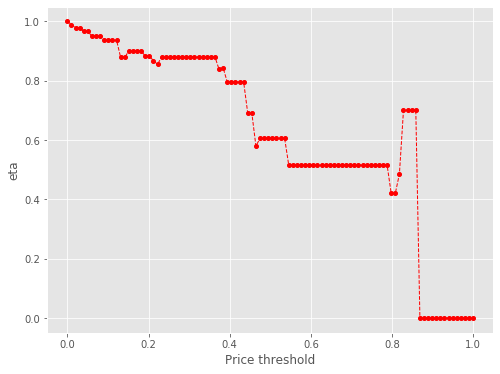

1630 28
Number of cells with price above 27.0th percentile:  28


eta =  1.0
eta =  0.9874119040203349
eta =  0.9874119040203349
eta =  0.9707964297621386
eta =  0.970682600120342
eta =  0.970682600120342
eta =  0.9570767701760514
eta =  0.9570767701760514
eta =  0.9570767701760514
eta =  0.8976848475396496
eta =  0.8976848475396496
eta =  0.8976848475396496
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.902172244571058
eta =  0.902172244571058
eta =  0.8868901415514604
eta =  0.8739992948834704
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8569841997112445
eta =  0.8569841997112445
eta =  0.8617047212471863
eta =  0.8134665210370634
eta =  0.8134665210370634
eta =

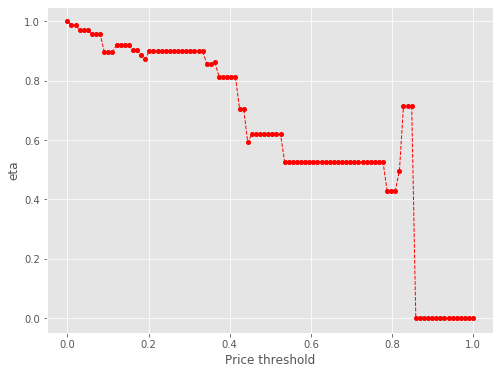

1630 28
Number of cells with price above 28.000000000000004th percentile:  28


eta =  1.0
eta =  0.9874119040203349
eta =  0.9874119040203349
eta =  0.9707964297621386
eta =  0.970682600120342
eta =  0.970682600120342
eta =  0.9570767701760514
eta =  0.9570767701760514
eta =  0.9570767701760514
eta =  0.8976848475396496
eta =  0.8976848475396496
eta =  0.8976848475396496
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.9205241809123634
eta =  0.902172244571058
eta =  0.902172244571058
eta =  0.8868901415514604
eta =  0.8739992948834704
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8997516896025018
eta =  0.8569841997112445
eta =  0.8569841997112445
eta =  0.8617047212471863
eta =  0.8134665210370634
eta =  0.8134665210370634
eta =

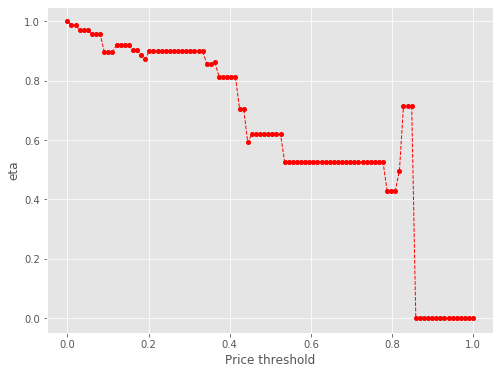

1630 27
Number of cells with price above 29.000000000000004th percentile:  27


eta =  1.0
eta =  0.9831727021007698
eta =  0.9830574212931017
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9091290512952562
eta =  0.9091290512952562
eta =  0.9091290512952562
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.913673656250025
eta =  0.913673656250025
eta =  0.9243913070047741
eta =  0.8851415415642702
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.8679095281533042
eta =  0.8679095281533042
eta =  0.8238370610329515
eta =  0.8238370610329515
eta =  0.8238370610329515
eta =  0.8238370610329515
eta

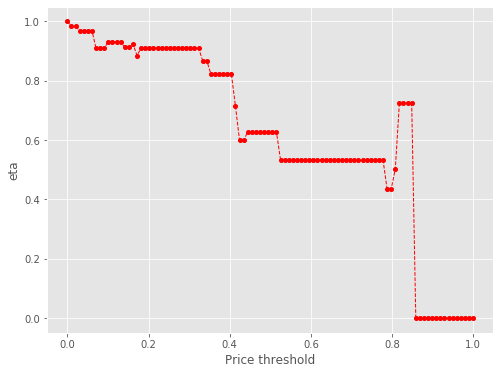

1630 27
Number of cells with price above 30.0th percentile:  27


eta =  1.0
eta =  0.9831727021007698
eta =  0.9830574212931017
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9692781363878932
eta =  0.9091290512952562
eta =  0.9091290512952562
eta =  0.9091290512952562
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.9322595536516907
eta =  0.913673656250025
eta =  0.913673656250025
eta =  0.9243913070047741
eta =  0.8851415415642702
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.9112222426518085
eta =  0.8679095281533042
eta =  0.8679095281533042
eta =  0.8238370610329515
eta =  0.8238370610329515
eta =  0.8238370610329515
eta =  0.8238370610329515
eta

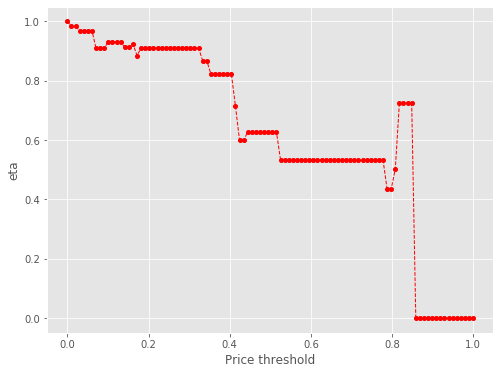

1630 25
Number of cells with price above 31.0th percentile:  25


eta =  1.0
eta =  0.9998827461264722
eta =  0.9858676245961796
eta =  0.9858676245961796
eta =  0.9858676245961796
eta =  0.9858676245961796
eta =  0.9246890697358636
eta =  0.9246890697358636
eta =  0.9246890697358636
eta =  0.9482154576298837
eta =  0.9482154576298837
eta =  0.9482154576298837
eta =  0.9482154576298837
eta =  0.9293114569777573
eta =  0.9293114569777573
eta =  0.9135696366011188
eta =  0.9002910065270995
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.9268180866950202
eta =  0.882764061999301
eta =  0.882764061999301
eta =  0.8379372812860224
eta =  0.8379372812860224
eta =  0.8379372812860224
eta =  0.8379372812860224
eta =  0.8379372812860224
eta

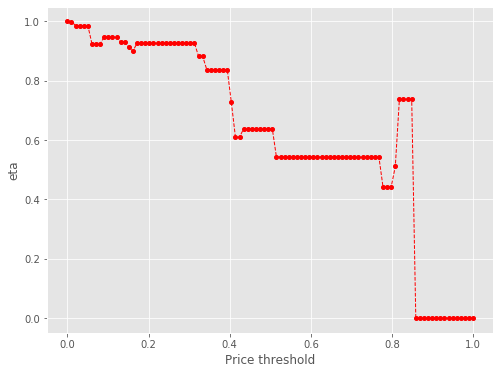

1630 24
Number of cells with price above 32.0th percentile:  24


eta =  1.0
eta =  0.9859832349497109
eta =  0.9859832349497109
eta =  0.9859832349497109
eta =  0.9859832349497109
eta =  0.9247975058256506
eta =  0.9247975058256506
eta =  0.948326652603271
eta =  0.948326652603271
eta =  0.948326652603271
eta =  0.948326652603271
eta =  0.9215842214581688
eta =  0.9294204351239115
eta =  0.94032280005459
eta =  0.9003965815139932
eta =  0.9003965815139932
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.9269267724495666
eta =  0.8828675816430608
eta =  0.8828675816430608
eta =  0.8380355441997338
eta =  0.8380355441997338
eta =  0.8380355441997338
eta =  0.8380355441997338
eta =  0.8380355441997338
eta =  0.8380355441997338
eta =  

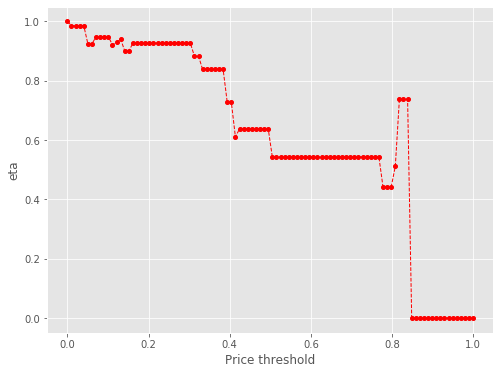

1630 23
Number of cells with price above 33.0th percentile:  23


eta =  1.0
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.9426331018410427
eta =  0.9426331018410427
eta =  0.9536904550943508
eta =  0.9131966443221694
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.8954184517022651
eta =  0.8954184517022651
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.7376992373194806
eta =  0.6187618548959415
eta =

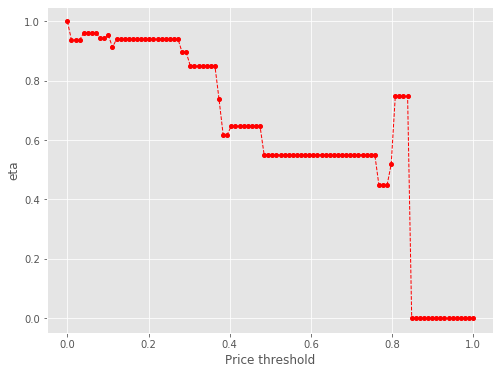

1630 23
Number of cells with price above 34.0th percentile:  23


eta =  1.0
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.9426331018410427
eta =  0.9426331018410427
eta =  0.9536904550943508
eta =  0.9131966443221694
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.8954184517022651
eta =  0.8954184517022651
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.7376992373194806
eta =  0.6187618548959415
eta =

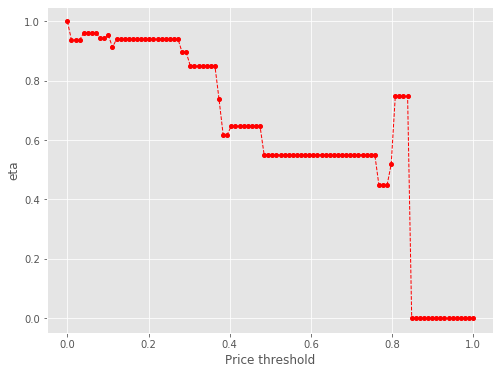

1630 23
Number of cells with price above 35.0th percentile:  23


eta =  1.0
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.9379444528514919
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.961808090633143
eta =  0.9426331018410427
eta =  0.9426331018410427
eta =  0.9536904550943508
eta =  0.9131966443221694
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.9401039891888664
eta =  0.8954184517022651
eta =  0.8954184517022651
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.8499490807695904
eta =  0.7376992373194806
eta =  0.6187618548959415
eta =

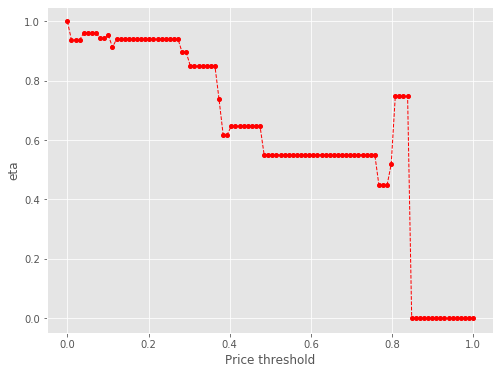

1630 22
Number of cells with price above 36.00000000000001th percentile:  22


eta =  1.0
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0049988557161318
eta =  1.0049988557161318
eta =  1.01678777692537
eta =  0.973614846322631
eta =  0.973614846322631
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  0.96876048620088
eta =  0.9546604268302441
eta =  0.9620918279267611
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.7865063171670393
eta =  0.6596998926906734
eta =  0.6596998926906734
eta =  0.6899829021452816
eta =  

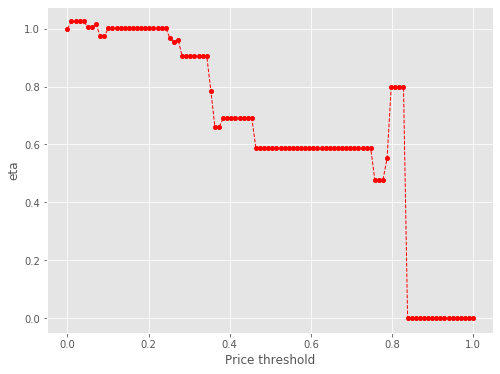

1630 22
Number of cells with price above 37.0th percentile:  22


eta =  1.0
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0254424851163648
eta =  1.0049988557161318
eta =  1.0049988557161318
eta =  1.01678777692537
eta =  0.973614846322631
eta =  0.973614846322631
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  1.0023024138911523
eta =  0.96876048620088
eta =  0.9546604268302441
eta =  0.9620918279267611
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.9061827469479857
eta =  0.7865063171670393
eta =  0.6596998926906734
eta =  0.6596998926906734
eta =  0.6899829021452816
eta =  

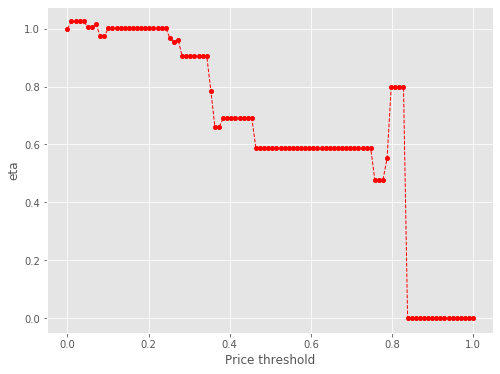

1630 21
Number of cells with price above 38.0th percentile:  21


eta =  1.0
eta =  0.9800636021064475
eta =  0.9800636021064475
eta =  0.9915600257287829
eta =  0.9494582684587595
eta =  0.9494582684587595
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9447243509624503
eta =  0.9309741313496597
eta =  0.9361022112348216
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.766992131282515
eta =  0.6433319296457783
eta =  0.6433319296457783
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.

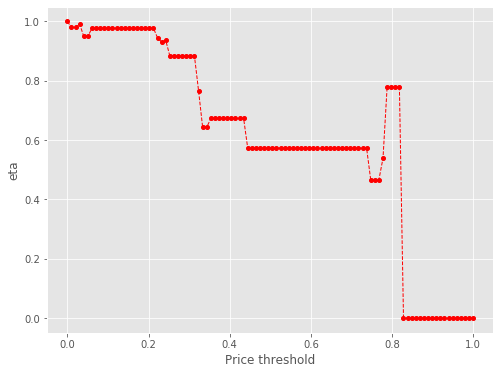

1630 21
Number of cells with price above 39.0th percentile:  21


eta =  1.0
eta =  0.9800636021064475
eta =  0.9800636021064475
eta =  0.9915600257287829
eta =  0.9494582684587595
eta =  0.9494582684587595
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9774340623086367
eta =  0.9447243509624503
eta =  0.9309741313496597
eta =  0.9361022112348216
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.883699242132682
eta =  0.766992131282515
eta =  0.6433319296457783
eta =  0.6433319296457783
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.6728635805127421
eta =  0.

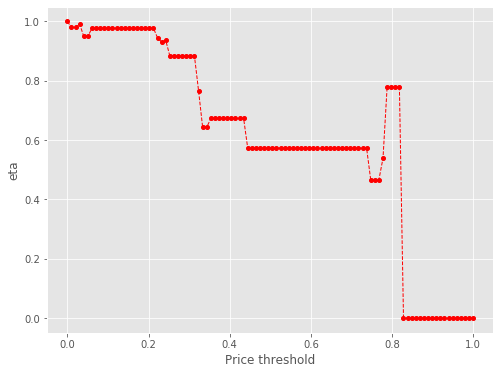

1630 20
Number of cells with price above 40.0th percentile:  20


eta =  1.0
eta =  1.0085029815867983
eta =  1.0203330071849235
eta =  0.977009545681401
eta =  0.977009545681401
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  1.0057971380878727
eta =  0.9579890378832127
eta =  0.9579890378832127
eta =  0.9632659238351913
eta =  0.9093423310500686
eta =  0.9093423310500686
eta =  0.9093423310500686
eta =  0.9093423310500686
eta =  0.9093423310500686
eta =  0.9093423310500686
eta =  0.7892486258948078
eta =  0.7892486258948078
eta =  0.662000065917444
eta =  0.662000065917444
eta =  0.692388663031449
eta =  0.692388663031449
eta =  0.692388663031449
eta =  0.692388663031449
eta =  0.

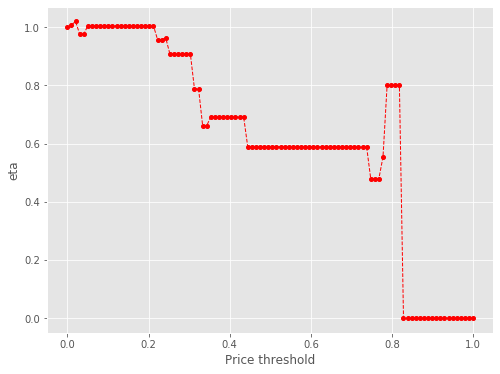

1630 19
Number of cells with price above 41.0th percentile:  19


eta =  1.0
eta =  0.9687720944009061
eta =  0.9687720944009061
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9973169702536049
eta =  0.9639418798248984
eta =  0.9499119540290243
eta =  0.9499119540290243
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.9016754017120421
eta =  0.782594241469657
eta =  0.782594241469657
eta =  0.6564185510645096
eta =  0.6564185510645096
eta =  0.6865509330889941
eta =  0.6865509330889941
eta =  0.6865509330889941
eta =  0.6865509330889941
eta =  0.6865509330889941
eta

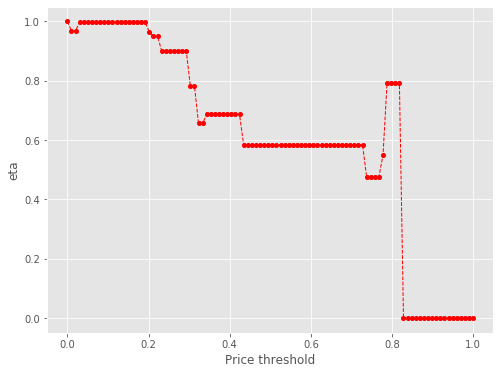

1630 16
Number of cells with price above 42.00000000000001th percentile:  16


eta =  1.0
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  1.0294650062875224
eta =  0.9805319120143061
eta =  0.9805319120143061
eta =  0.9859329707606649
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.9307404774800445
eta =  0.8078207929323331
eta =  0.8078207929323331
eta =  0.6775778894317166
eta =  0.6775778894317166
eta =  0.7086815743939867
eta =  0.7086815743939867
eta =  0.7086815743939867
eta =  0.7086815743939867
eta =  0.7086815743939867
eta =  0.7086815743939867
eta =  0.7086815743939867
e

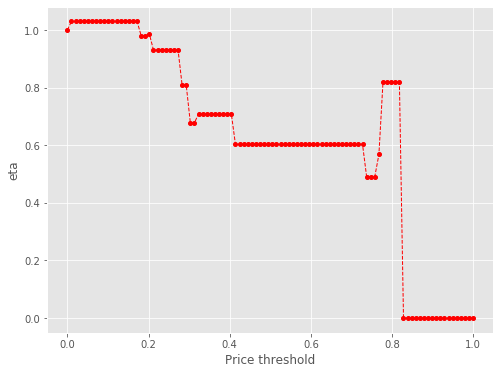

1630 15
Number of cells with price above 43.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

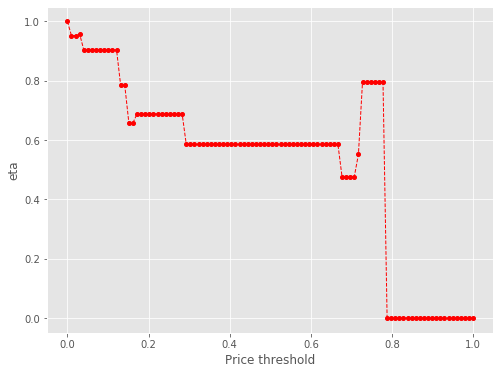

1630 15
Number of cells with price above 44.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

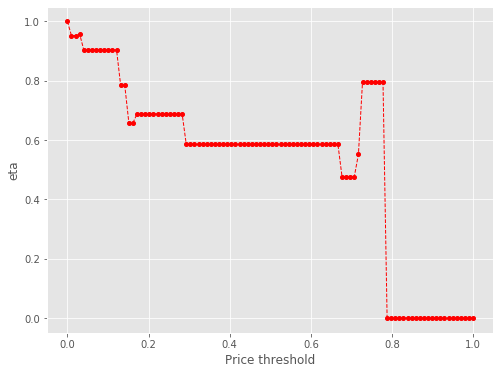

1630 15
Number of cells with price above 45.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

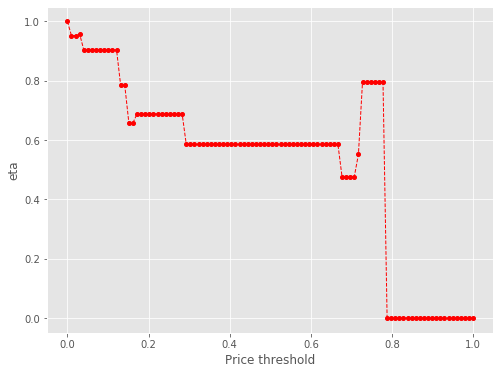

1630 15
Number of cells with price above 46.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

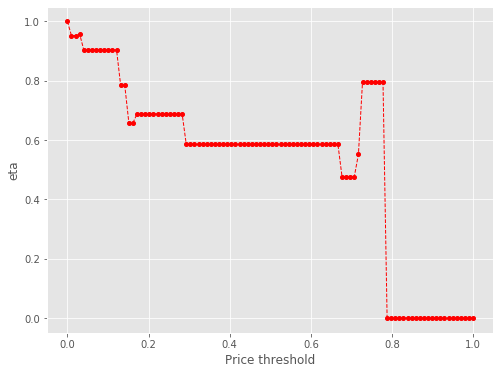

1630 15
Number of cells with price above 47.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

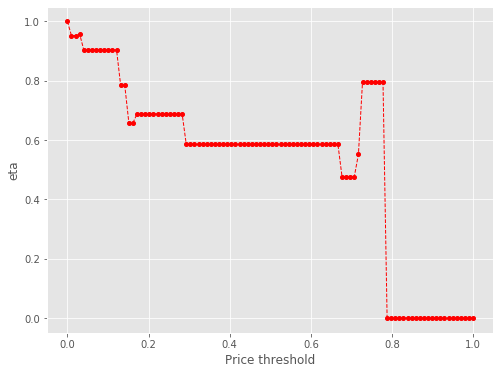

1630 15
Number of cells with price above 48.00000000000001th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

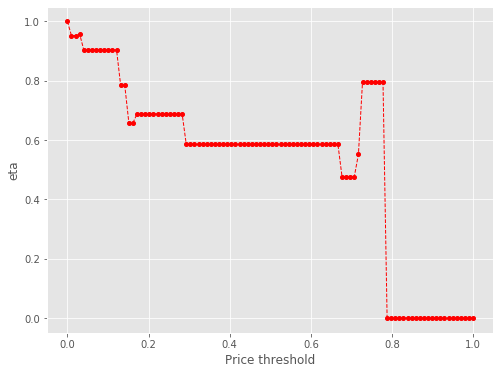

1630 15
Number of cells with price above 49.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

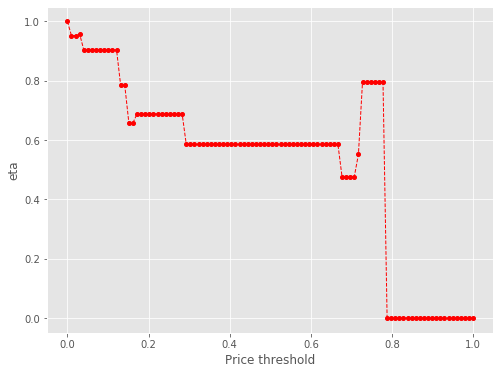

1630 15
Number of cells with price above 50.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

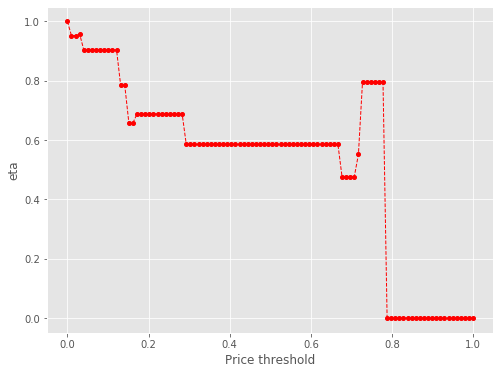

1630 15
Number of cells with price above 51.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

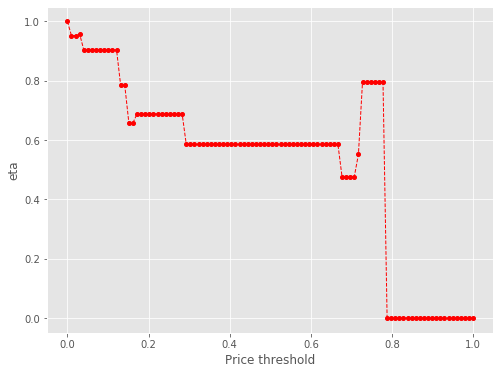

1630 15
Number of cells with price above 52.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

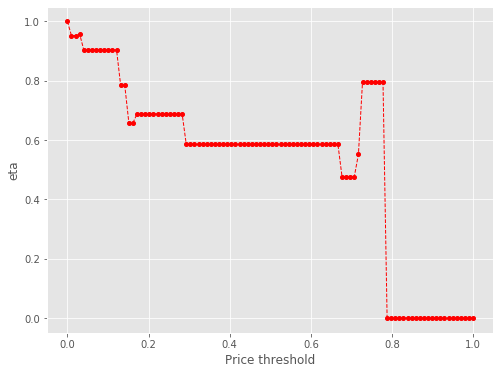

1630 15
Number of cells with price above 53.0th percentile:  15


eta =  1.0
eta =  0.9524674525366533
eta =  0.9524674525366533
eta =  0.9577139239692629
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.9041011319427941
eta =  0.7846996138756701
eta =  0.7846996138756701
eta =  0.6581844796018971
eta =  0.6581844796018971
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.6883979251996615
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
eta =  0.5858517915458505
e

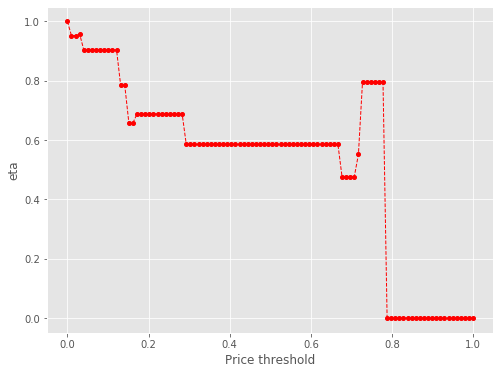

1630 13
Number of cells with price above 54.0th percentile:  13


eta =  1.0
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.9492199754804767
eta =  0.8238597673713927
eta =  0.8238597673713927
eta =  0.6910309405838396
eta =  0.6910309405838396
eta =  0.6910309405838396
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.7227521773749745
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
eta =  0.6150885156081546
e

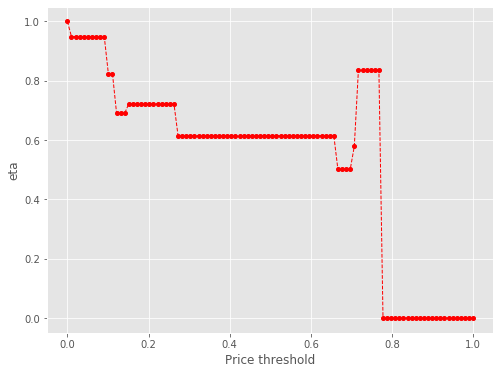

1630 9
Number of cells with price above 55.00000000000001th percentile:  9


eta =  1.0
eta =  0.8679334492032481
eta =  0.8679334492032481
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta 

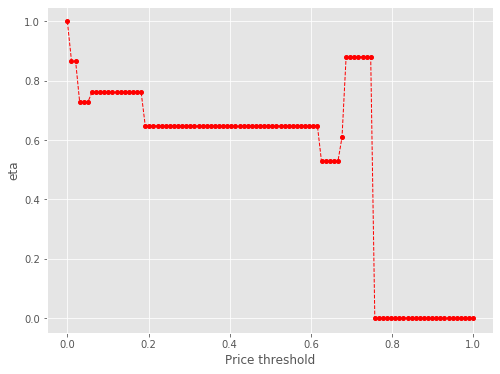

1630 9
Number of cells with price above 56.00000000000001th percentile:  9


eta =  1.0
eta =  0.8679334492032481
eta =  0.8679334492032481
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta 

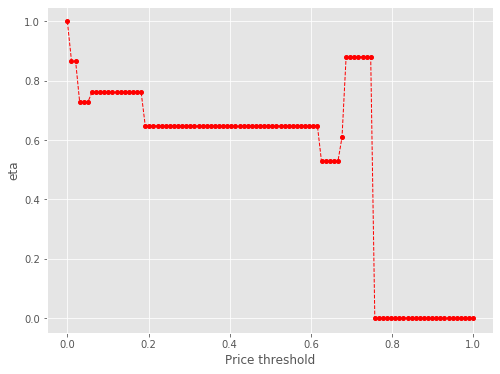

1630 9
Number of cells with price above 57.00000000000001th percentile:  9


eta =  1.0
eta =  0.8679334492032481
eta =  0.8679334492032481
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta 

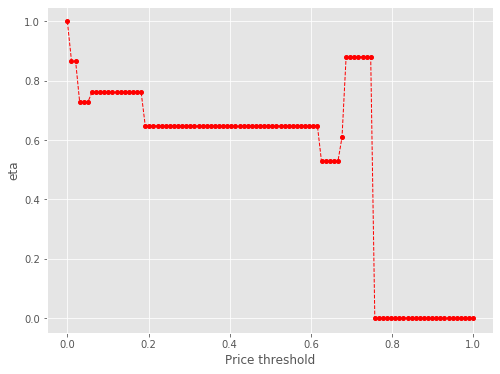

1630 9
Number of cells with price above 58.00000000000001th percentile:  9


eta =  1.0
eta =  0.8679334492032481
eta =  0.8679334492032481
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.727998734154381
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.7614169486995167
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta =  0.6479936489924886
eta 

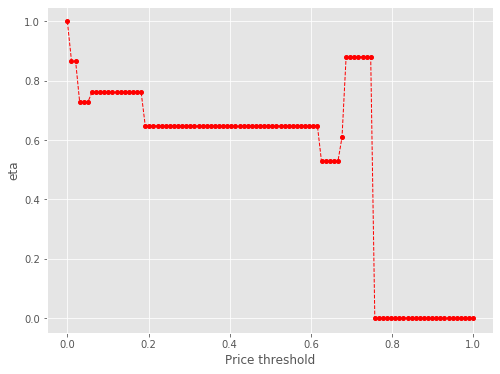

1630 8
Number of cells with price above 59.0th percentile:  8


eta =  1.0
eta =  0.8387725289567705
eta =  0.8387725289567705
eta =  0.8387725289567705
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.877275728223734
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.7465937043759963
eta =  0.74659

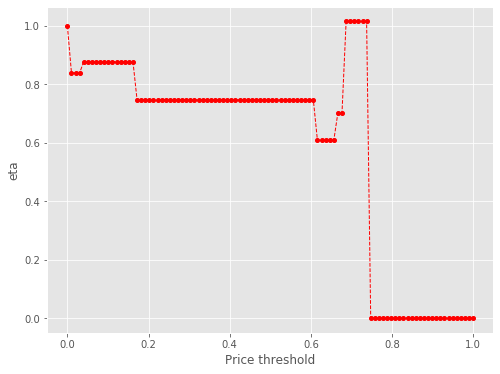

1630 7
Number of cells with price above 60.0th percentile:  7


eta =  1.0
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
e

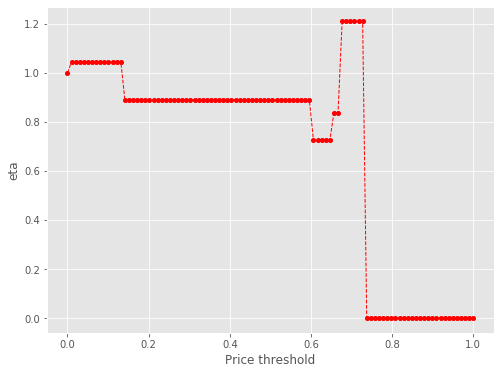

1630 7
Number of cells with price above 61.0th percentile:  7


eta =  1.0
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  1.0459042206769125
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
eta =  0.8901027139081173
e

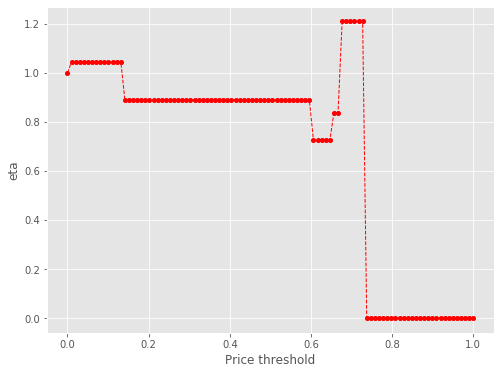

1630 6
Number of cells with price above 62.0th percentile:  6


eta =  1.0
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
e

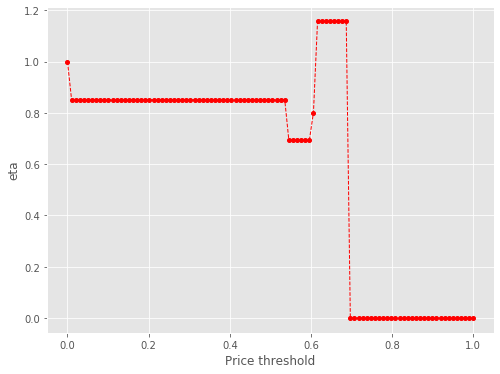

1630 6
Number of cells with price above 63.0th percentile:  6


eta =  1.0
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
e

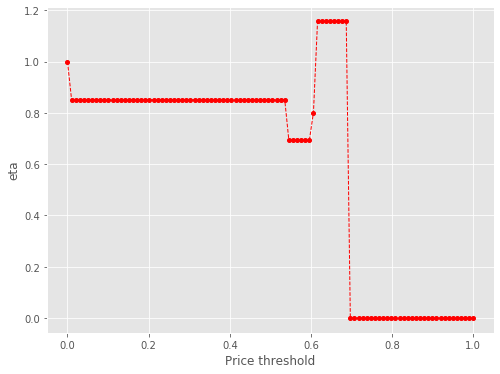

1630 6
Number of cells with price above 64.0th percentile:  6


eta =  1.0
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
e

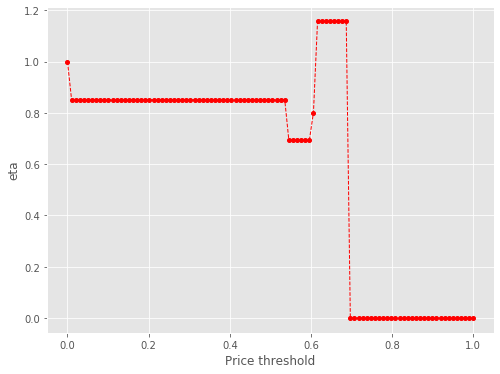

1630 6
Number of cells with price above 65.0th percentile:  6


eta =  1.0
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
e

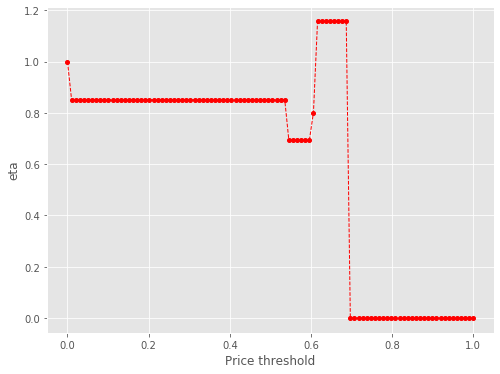

1630 6
Number of cells with price above 66.0th percentile:  6


eta =  1.0
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
eta =  0.8510365445624074
e

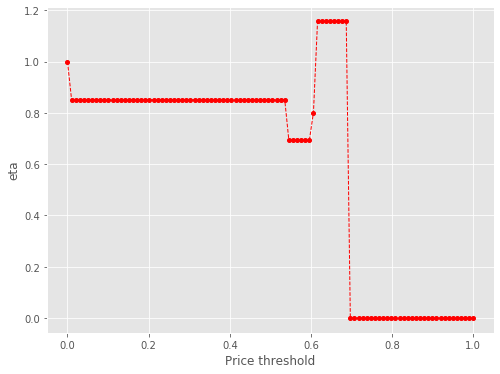

1630 5
Number of cells with price above 67.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

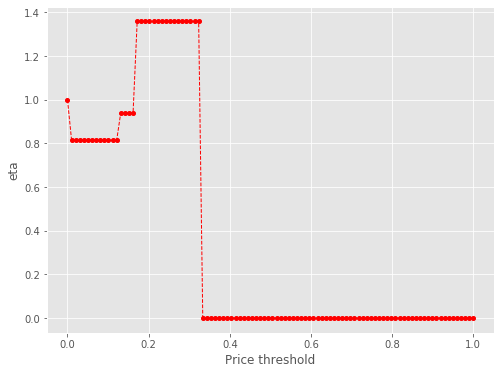

1630 5
Number of cells with price above 68.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

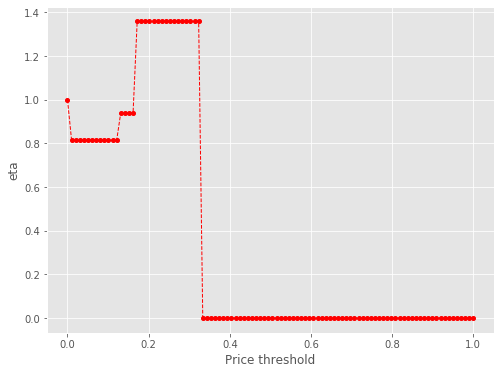

1630 5
Number of cells with price above 69.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

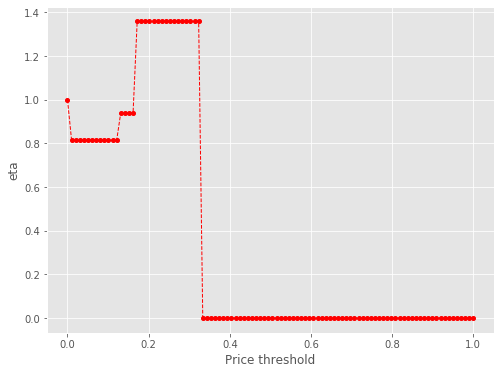

1630 5
Number of cells with price above 70.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

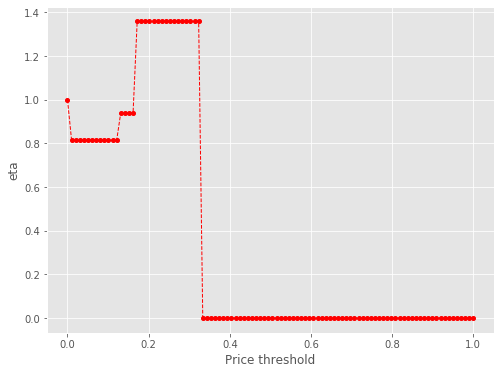

1630 5
Number of cells with price above 71.00000000000001th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

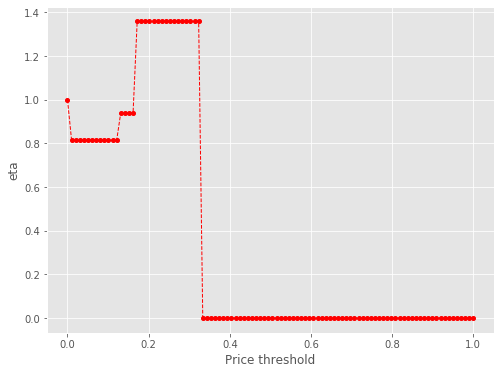

1630 5
Number of cells with price above 72.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

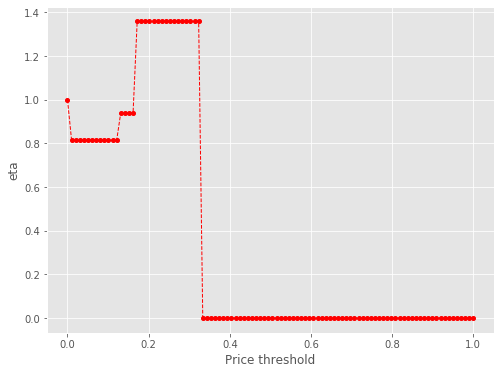

1630 5
Number of cells with price above 73.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

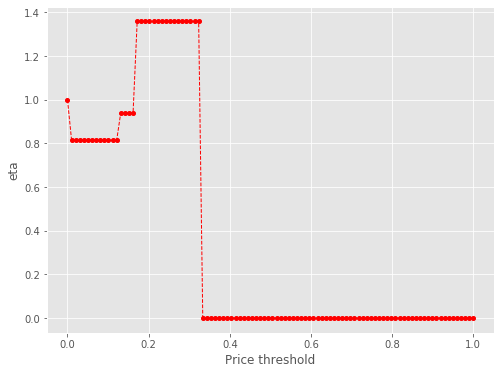

1630 5
Number of cells with price above 74.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

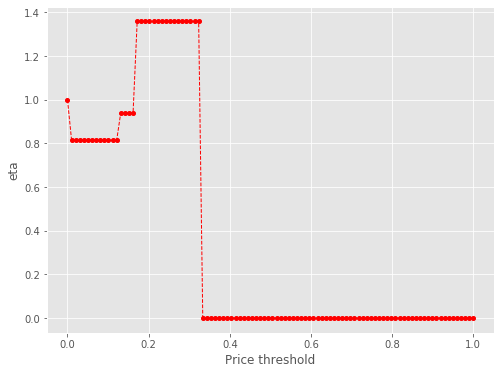

1630 5
Number of cells with price above 75.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

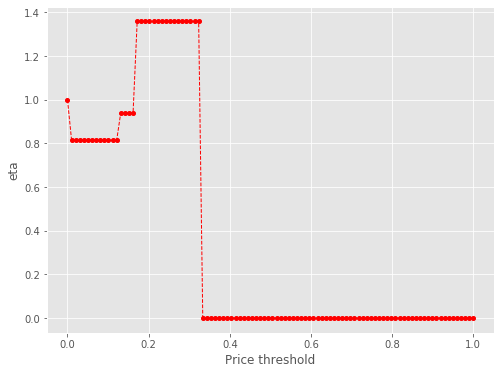

1630 5
Number of cells with price above 76.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

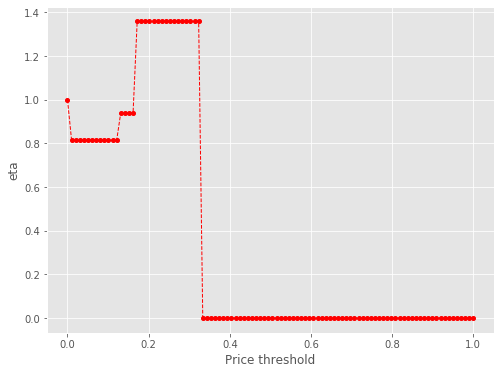

1630 5
Number of cells with price above 77.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

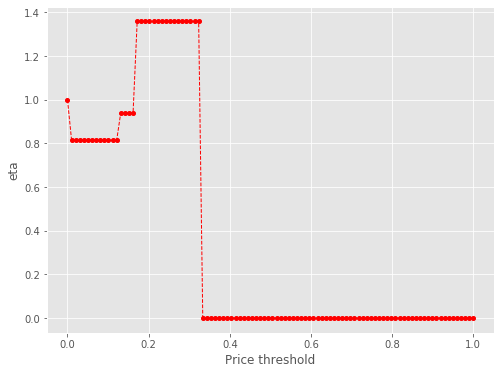

1630 5
Number of cells with price above 78.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

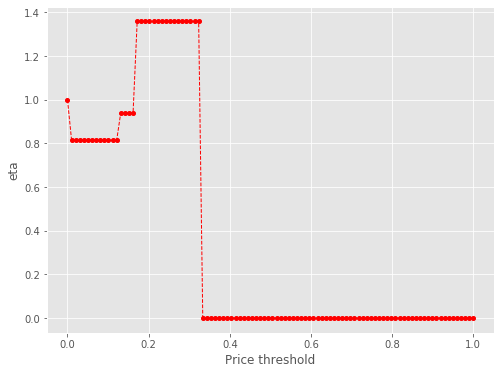

1630 5
Number of cells with price above 79.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

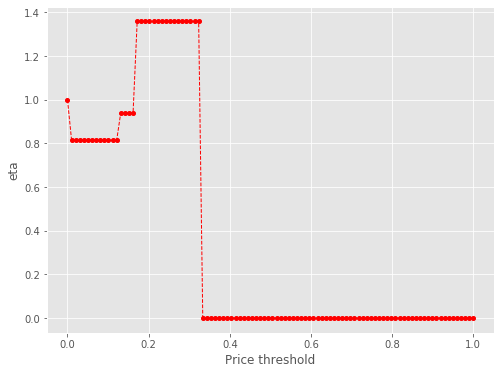

1630 5
Number of cells with price above 80.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

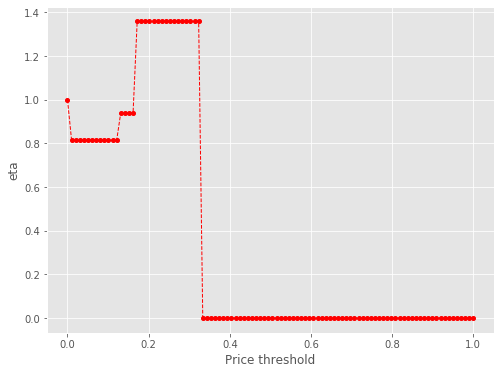

1630 5
Number of cells with price above 81.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

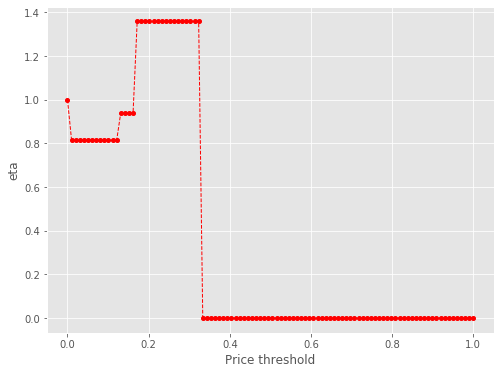

1630 5
Number of cells with price above 82.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

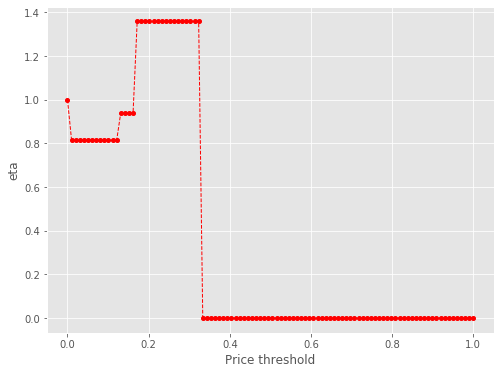

1630 5
Number of cells with price above 83.0th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

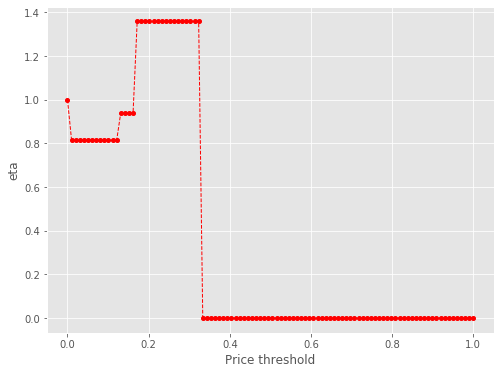

1630 5
Number of cells with price above 84.00000000000001th percentile:  5


eta =  1.0
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.8143999629018202
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  0.9410897374920524
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  1.3587730600230568
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta

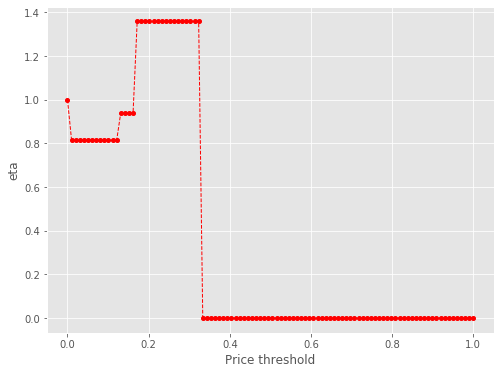

1630 4
Number of cells with price above 85.0th percentile:  4


eta =  1.0
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

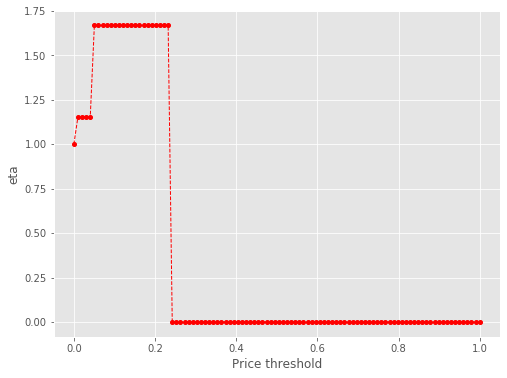

1630 4
Number of cells with price above 86.0th percentile:  4


eta =  1.0
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.1555621075163351
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  1.6684345799594094
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta = 

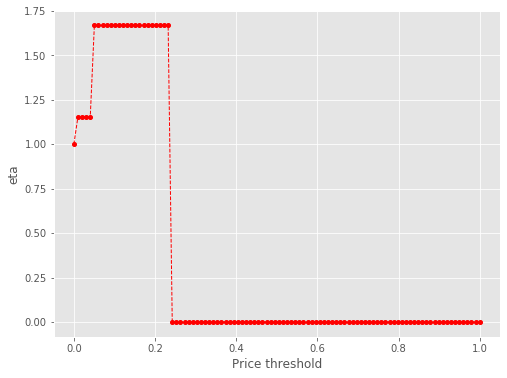

1630 3
Number of cells with price above 87.0th percentile:  3


eta =  1.0
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  1.4438294308086976
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


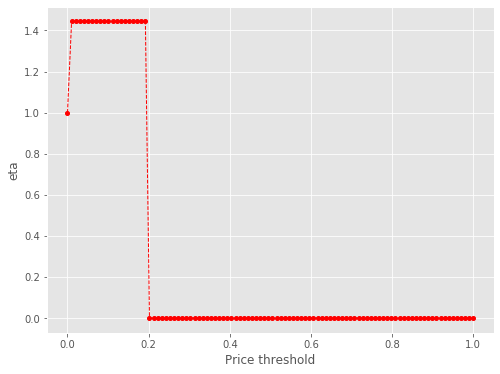

1630 2
Number of cells with price above 88.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

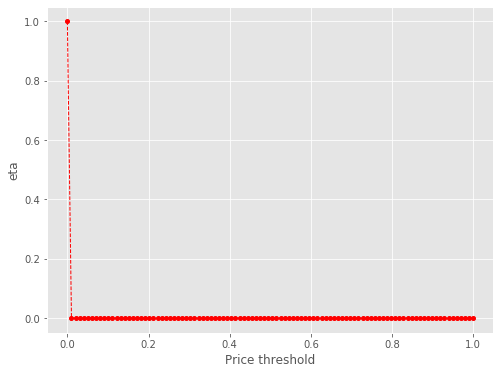

1630 2
Number of cells with price above 89.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

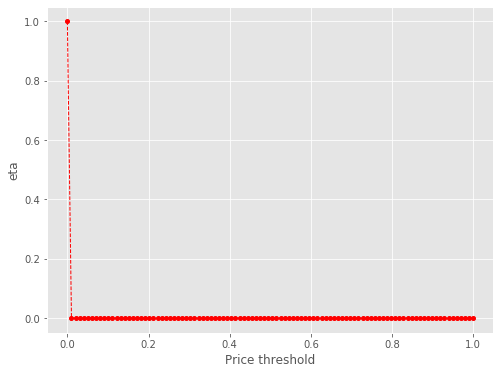

1630 1
Number of cells with price above 90.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



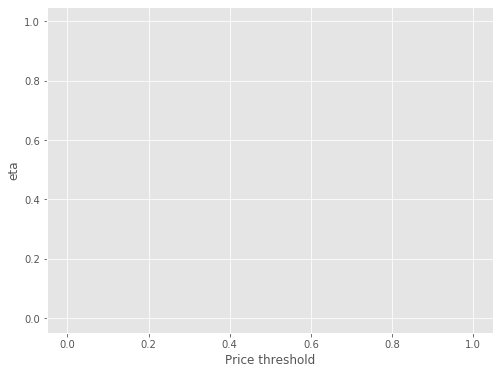

1630 1
Number of cells with price above 91.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

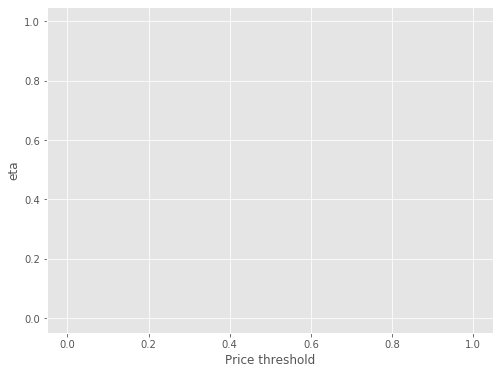

1630 1
Number of cells with price above 92.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

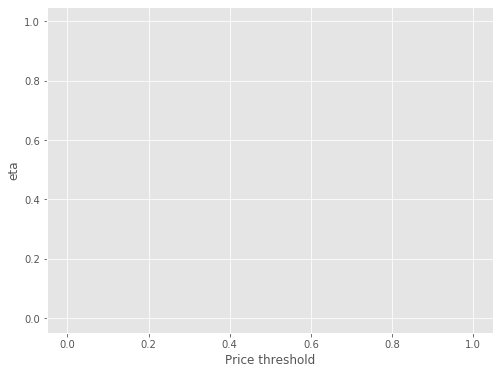

1630 1
Number of cells with price above 93.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

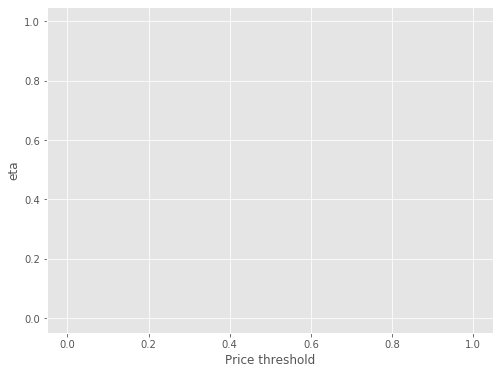

1630 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

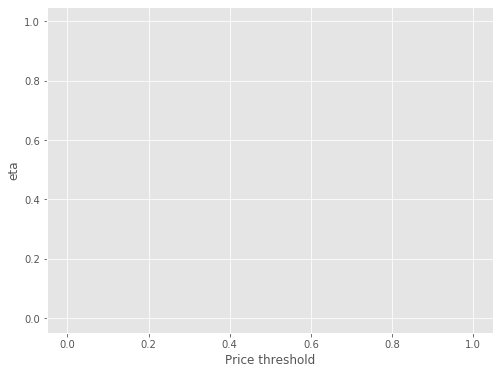

1630 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

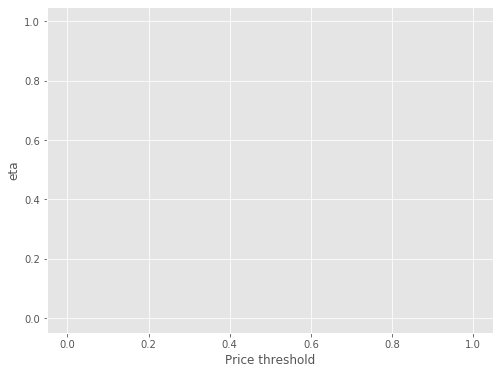

1630 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

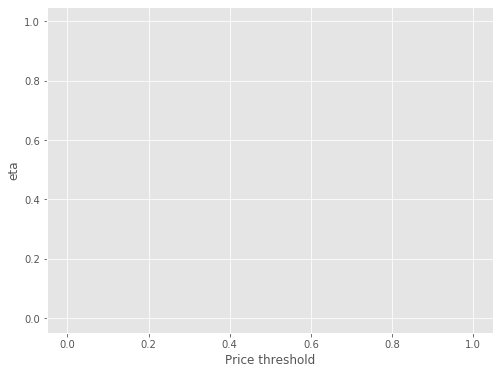

1630 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

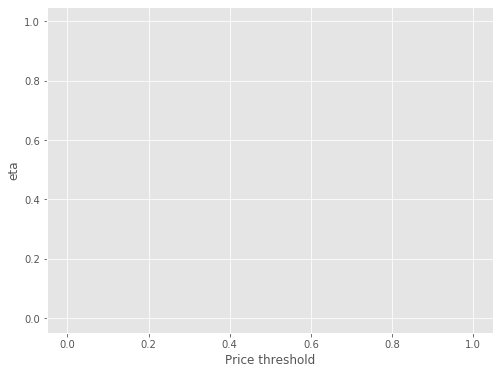

1630 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

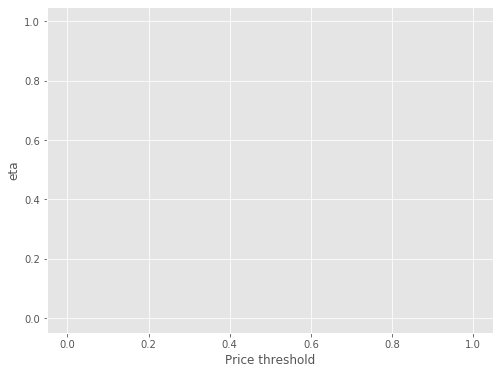

1630 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

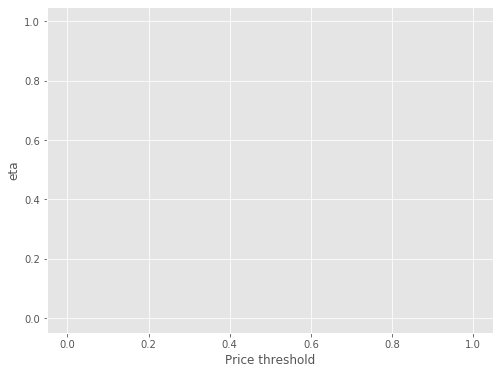

1630 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

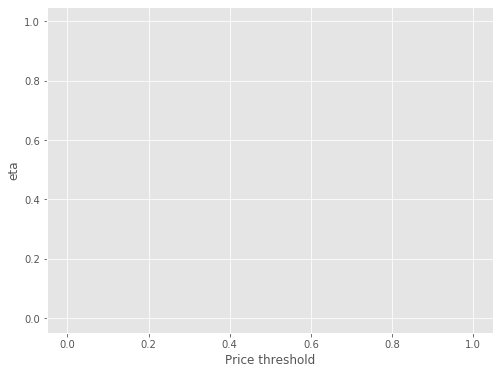


time: 1min 8s


In [28]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

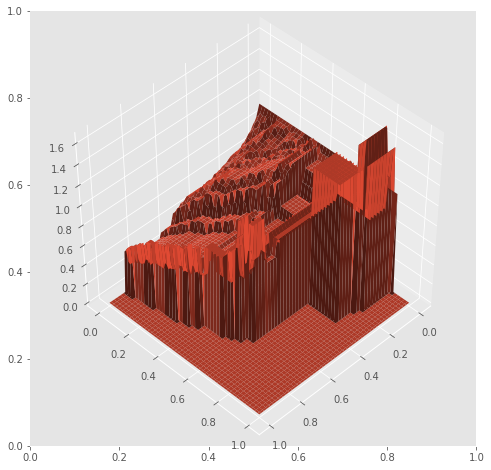

time: 1.02 s


In [29]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [30]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Brno'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 30 ms


1630 66
Number of cells with price above 5th percentile:  66
total number of cells:  1630
number of cells within urban airbnb territory:  66



Mean travel times in minutes:  6.945996334310849
Mean travel times in minutes:  13.097245438253504


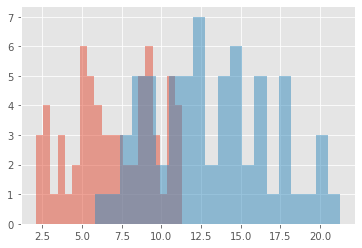

time: 13.5 s


In [32]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.1)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

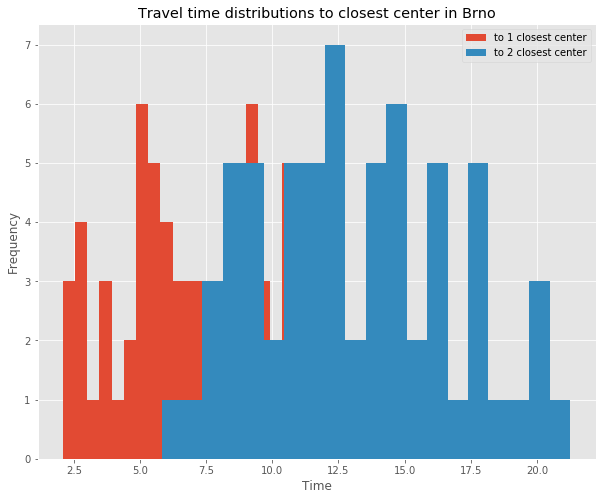

time: 372 ms


In [33]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Brno')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [34]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Brno'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 708 ms


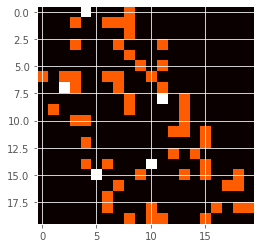

time: 181 ms


In [35]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [36]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.883410515813205
1.602784155150813
2.804006081279192
average mutual information =  2.4300669174144036
time: 12 ms


In [37]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Brno'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,
 

time: 8.98 ms
